In [109]:
%config InlineBackend.figure_format = 'retina'


In [110]:
# ML
import torch
import torch.nn as nn
from sklearn import datasets

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.patches import Circle, Wedge, Polygon

# Math
import math
from math import cos, sin
import numpy as np
import random

## 1 Neural Network

In [111]:



def train(x,y,model,crit):
    for epoch in range(1000):
        y_pred = model(x)

        #get loss
        loss = crit(y_pred,y)
#         print('epoch: ', epoch,' loss: ', loss.item())

        #zero grad
        optimizer.zero_grad()

        #back pass
        loss.backward()
        #update params
        optimizer.step()
    return loss



In [112]:
def pred(model,x):
    return model(torch.FloatTensor(x)).tolist()



def rand_points():
    x_points = np.linspace(0,10,200)
    y_points = np.linspace(0,10,200)
    points = [[x,y] for x in x_points for y in y_points]
    return points

def train_vals(x):
    return ([z[0] for z in x.tolist()],[z[1] for z in x.tolist()])



def plot_regions(x,y,model):
    x_train,y_train = train_vals(x)
    points = rand_points()
    x_map = [x[0] for x in points]
    y_map = [x[1] for x in points]
    preds = pred(model,points)
    
    
    #get colors
    c1 = ['g','b']
    c2 = ['#E2E79F','#FF90FF']
    
    train_map = [c1[int(x[0])] for x in y.tolist()]
    cmap = [c2[0] if x[0] < 0.5 else c2[1] for x in preds]
    #plot points
    print(len(x_map))
    plt.scatter(x_map,y_map,color=cmap)
    plt.scatter(x_train,y_train,color=train_map,marker='o')
    
    plt.xlabel('X1')
    plt.ylabel('X2')
    #show classification regions
    plt.show()

Underparameterize
40000


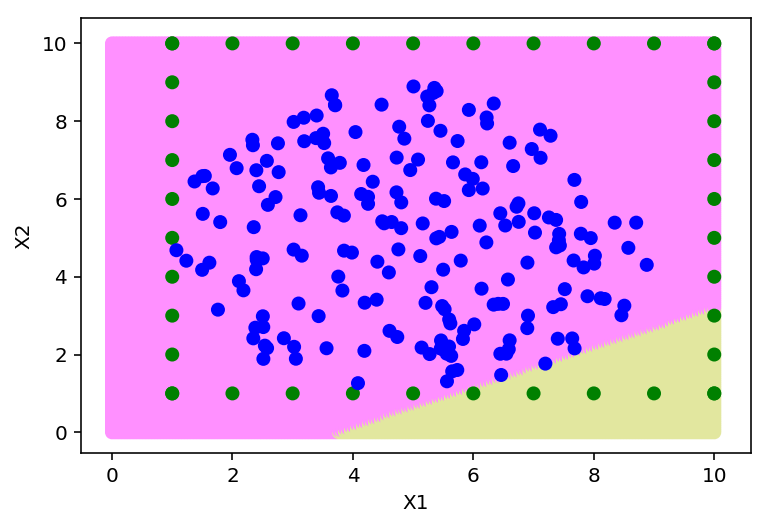

Overparameterize
40000


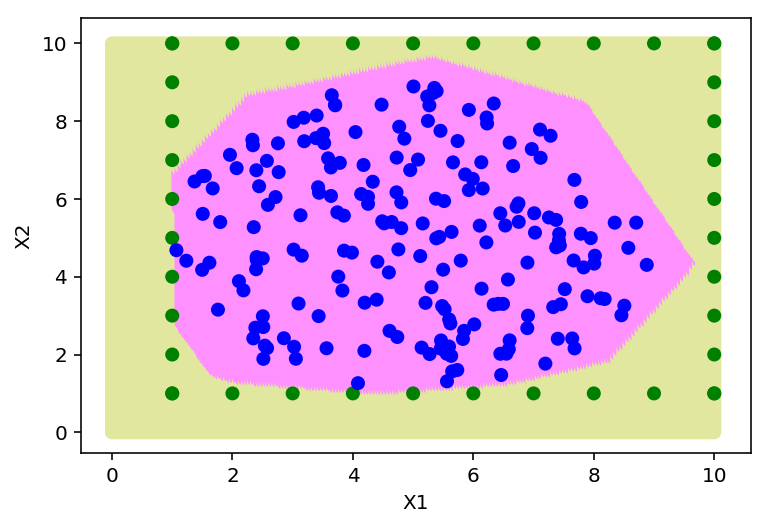

In [113]:
d = 2


#get data for new model
x1 = []
for z in range(1,11):
    x1.append([z,1])
    x1.append((1,z))
    x1.append((10,z))
    x1.append((z,10))
y1 = [[0] for x in range(len(x1))]
x2 = []
y2 = []
for z in range(200):
    r = 4 * (random.random() ** 0.5)
    theta = random.random() * 2 * 3.14159
    x = 5 + r * cos(theta)
    y = 5 + r * sin(theta)
    x2.append([x,y])
    y2.append([1])

x = x1 + x2
y = y1 + y2

x = torch.FloatTensor(x)
y = torch.FloatTensor(y)



print("Underparameterize")
H = 3
model = nn.Sequential(nn.Linear(d,H),
                     nn.ReLU(),
                     nn.Linear(H,1),
                      nn.Sigmoid())

crit = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
    
train(x,y,model,crit)
plot_regions(x,y,model)



print("Overparameterize")
H = 20
model = nn.Sequential(nn.Linear(d,H), # Shape: [2, 20]
                     nn.ReLU(),       # Shape: [20, 20]
                     nn.Linear(H,1),  # Shape: [20, 1]
                      nn.Sigmoid())   # Shape: [1, 1]

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
train(x,y,model,crit)
plot_regions(x,y,model)
    

Underparameterize
40000


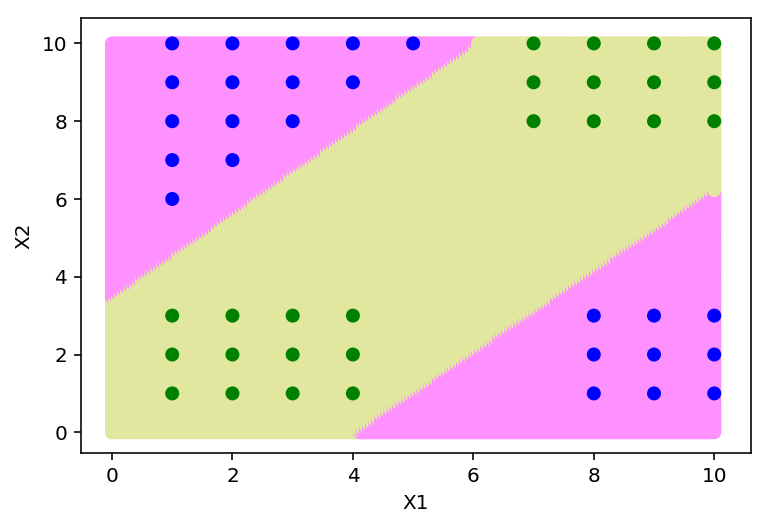

Overparameterize
called
40000


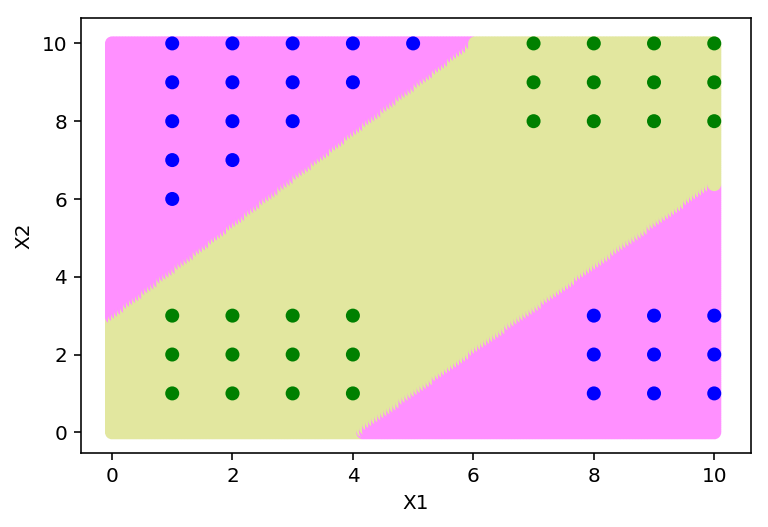

10
[1.71575767e-03 6.23516753e+00 0.00000000e+00 2.54472592e+00
 5.35461948e-04 4.66216549e+00 2.50176442e+00 3.80898916e+00
 2.99836732e+00 2.14905901e-04]


In [114]:

def load_data(file):
    x = []
    y = []
    with open(file) as f:
        for l in f:
            vals = [int(x) for x in l.split()]
            if vals == []:
                break
            x.append([vals[0],vals[1]])
            if vals[2] == 0 or vals[2] == 3:
                y.append([0])
            else:
                y.append([1])
    return x,y

x,y = load_data('data0.txt')
x = torch.FloatTensor(x)
y = torch.FloatTensor(y)

H = 3
print("Underparameterize")
model = nn.Sequential(nn.Linear(d,H),
                     nn.ReLU(),
                     nn.Linear(H,1),
                      nn.Sigmoid())

crit = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
train(x,y,model,crit)
plot_regions(x,y,model)
    

H = 10
print("Overparameterize")

model = nn.Sequential(nn.Linear(d,H),
                     nn.ReLU(),
                     nn.Linear(H,1),
                      nn.Sigmoid())




crit = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
train(x,y,model,crit)

o = []

def hook(module, input, output):
    print("called")
    o.append(output)
    
model[1].register_forward_hook(hook)


plot_regions(x,y,model)

print(len(o[0].tolist()[0]))
a = np.array(o[0].tolist())
t = np.sum(a, axis=0) / a.shape[0]
print(t)

In [115]:
# Notes

#how many different local optima are found?
#local optima are diff if different classification
# of training data
# decision boundry will be different every time, so it
# is not a  good measure

#also figure out how the weights are spread out
#visualize weights in relation to each other

#4 syntehtic data sets


#NN spread out weights

#look at SGD vs Adam

## 2 Synthetic data set generator

### 2.1 Generate circles and disks

In [116]:
def gen_circle(n, x, y, radius, disk_start=0, circ_start=0, circ_end=1, noise=False):
    """
    Generates points in within a specific disk.
    
    Args:
        - n: Number of points to generate
        - x: X-axis center of circle
        - y: Y-axis center of circle
        - radius:     Radius of circle
        - disk_start: [0, 1] where to start center of circle
        - circ_start: [0, 1] Start place of circle (Defaults 0 == 3PM).
        - circ_end:   [0, 1] End place of circle (Defaults 1 == 3PM, wraps around counter clockwise).
        - noise:      Add standard normal noise to data points
    """
    data = []
    for i in range(n):
        arc = random.uniform(circ_start, circ_end) * 2 * math.pi
        r = radius * np.sqrt(random.uniform(disk_start, 1))
        
        p_x = r * np.cos(arc) + x
        p_y = r * np.sin(arc) + y
        
        if noise:
            p_x += np.random.normal(0,1)
            p_y += np.random.normal(0,1)
            
        data.append([p_x, p_y])
    return data

### 2.2 Visualize two datasets

In [117]:
def plot(data1, data2):
    data1 = np.array(data1)
    data2 = np.array(data2)
    figure(num=None, figsize=(6, 6), dpi=120, facecolor='w', edgecolor='k')
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111, aspect='equal')



    axis = { 'xmin' : -10, 
             'xmax' : 10, 
             'ymin' : -10, 
             'ymax' : 10 }

    #ax2.add_artist(Circle((x, y), r, color=(1,0,0,.7)))
    plt.axis(**axis)
    plt.scatter(data1[:, 0], data1[:, 1])
    plt.scatter(data2[:, 0], data2[:, 1])
    plt.show()

## 3 Neural net visualization

### 3.1 Neural net hidden layer weight plot function

In [118]:

def show_weights(model):
    weights1 = np.array(model[0].weight.tolist())
    weights2 = np.array(model[2].weight.tolist())[0]
    print(weights1)
    #bias = np.array(model[-1].bias.tolist())
    
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

    plt.scatter(weights1[:,0], weights1[:,1], s=300, color='salmon', edgecolor='black', linewidths=2)
    
    m = np.max(np.abs(weights1))
    pad = .1 * m
    plt.xlim(-m - pad, m + pad)
    plt.ylim(-m - pad, m + pad)
    plt.title('Counts of Feature Variable Types')
    plt.xlabel('w1')
    plt.ylabel('w2')

    #plt.savefig('Var-Type-Bar.png')

    plt.show()
    
    plt.bar(list(range(len(weights2))), weights2)
    plt.show()
    
def show_layer(outputs):
    print(np.shape(outputs))
    plt.bar(list(range(len(outputs))), outputs)
    plt.show()

    
    
def test_set():
    x_points = np.linspace(0,10,200)
    y_points = np.linspace(0,10,200)
    points = [[x,y] for x in x_points for y in y_points]
    return points



def do_all(x,y,H):
    for ind in range(1):
        print('---------------------------------------------------------------')
        model = nn.Sequential(nn.Linear(d,H),
                             nn.ReLU(),
                             nn.Linear(H,1),
                              nn.Sigmoid())

        crit = torch.nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
        loss = train(x,y,model,crit)
        print("The loss is " + str(loss.tolist()))

        o = []

        def hook(module, input, output):
            o.append(output)

        model[1].register_forward_hook(hook)

        plot_regions(x,y,model)
        show_weights(model)
        a = np.array(o[0].tolist())
        t = np.sum(a, axis=0) / a.shape[0]




        #plot_regions(x,y,model)
        #show_weights(model)
        show_layer(t)
        print('---------------------------------------------------------------')

## Data set 1

<Figure size 720x720 with 0 Axes>

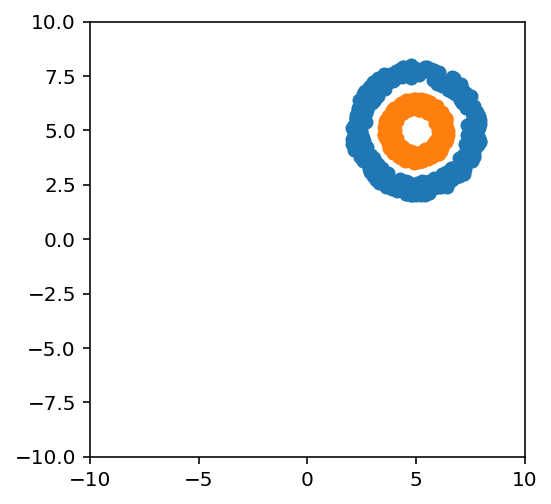

700
700


In [119]:
n = 250
r = 3
x = 5
y = 5

data1 = gen_circle(350, x, y, r, disk_start = .6, circ_start = 0 , circ_end = 1)
data2 = gen_circle(350, x, y, 1.5, disk_start = .4, circ_start = 0 , circ_end = 1)

plot(data1, data2)

x = torch.FloatTensor(data1 + data2)
y = ([[0]] * len(data1)) + ([[1]] * len(data2))
y = torch.FloatTensor(y)
print(len(x))
print(len(y))

The loss is 0.05321232229471207
40000


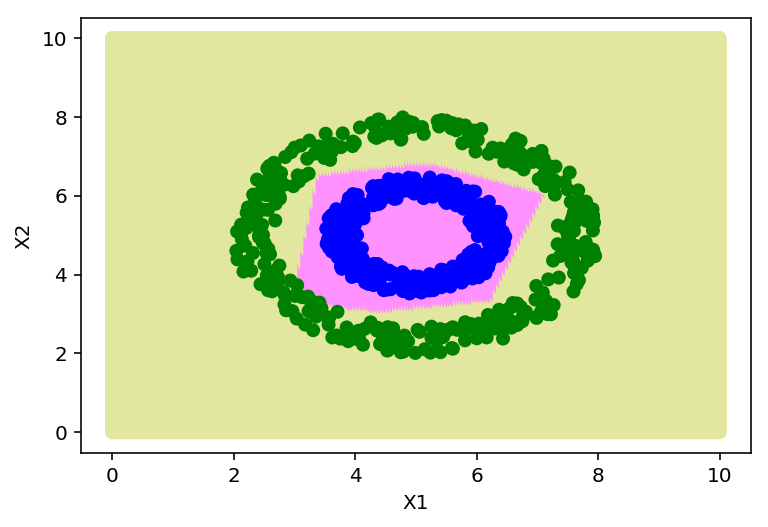

[[ 1.09470236 -0.16693795]
 [ 1.6533916  -2.6027596 ]
 [ 1.5225625  -0.03319615]
 [-0.83078706  0.25716621]
 [ 0.91904229  0.81942421]
 [-0.66236812 -0.31998301]
 [ 1.10883141  0.33513954]
 [-1.8048228   0.65591294]
 [ 0.32641608 -0.79176694]
 [-0.88963521  0.13876276]]


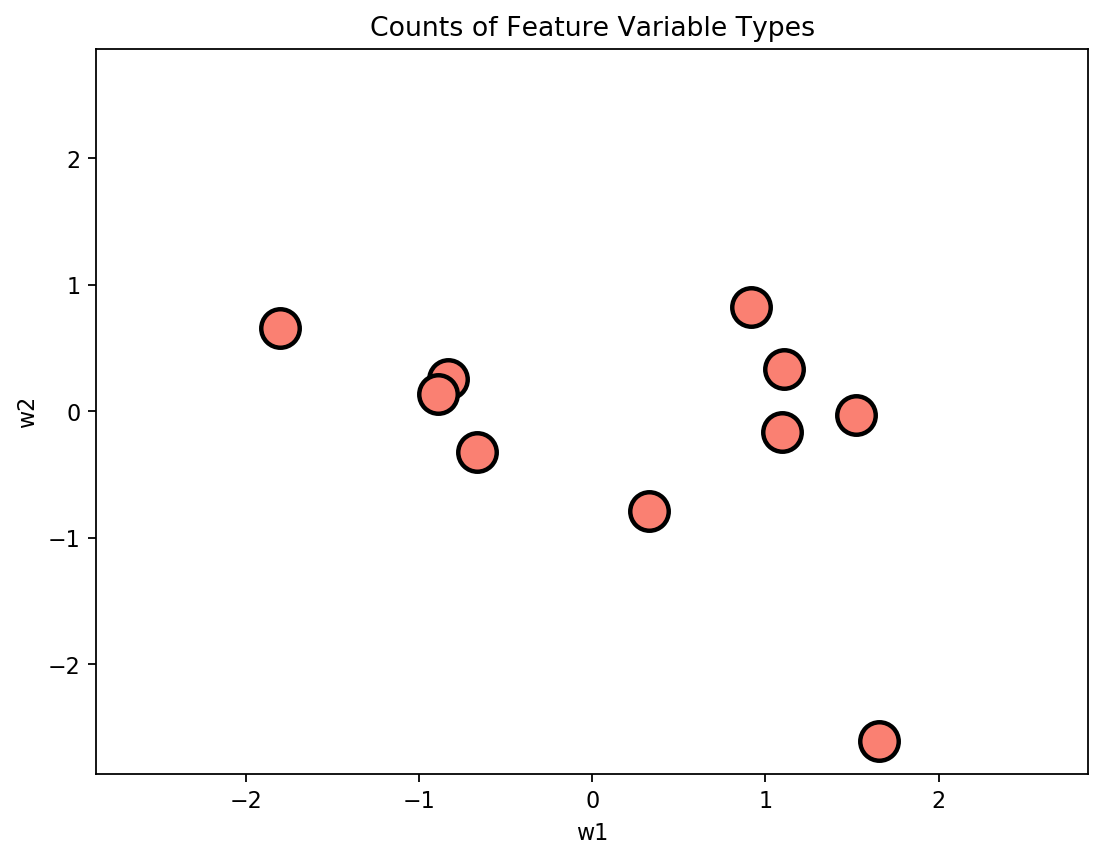

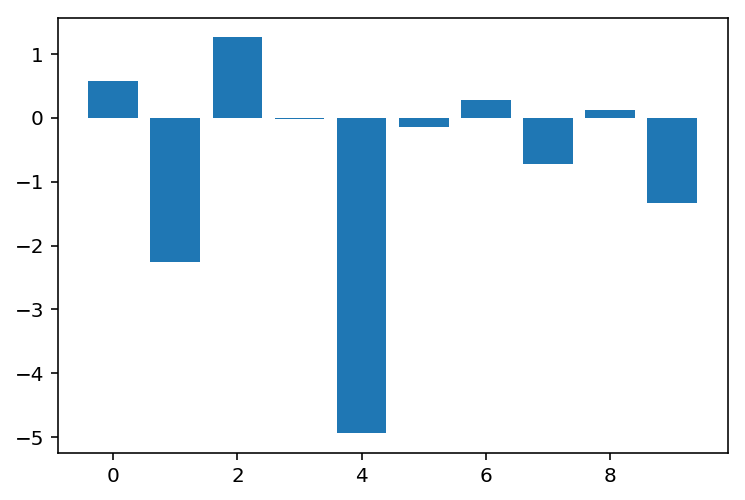

(10,)


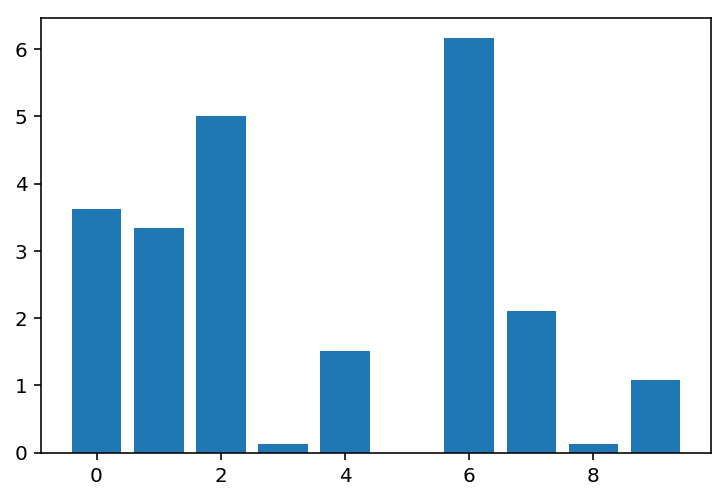

The loss is 0.00911086704581976
40000


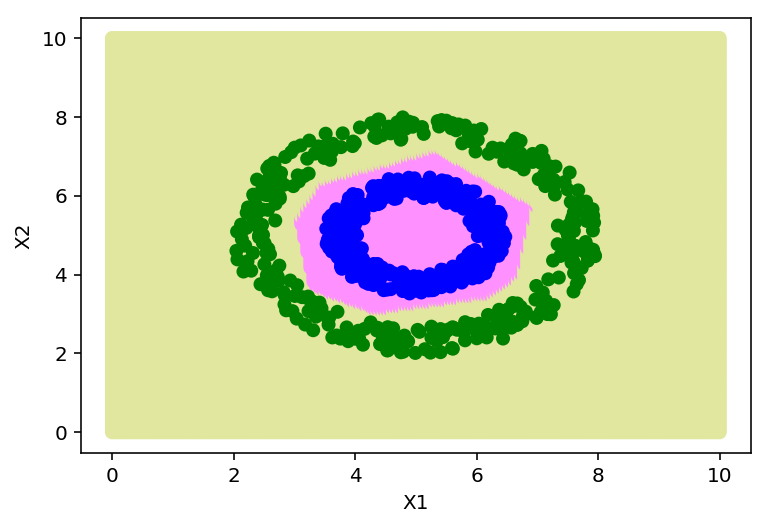

[[-0.41465172  0.17791516]
 [-0.06768972 -0.61594558]
 [ 2.29734159 -2.20308566]
 [-3.40333056  2.01303363]
 [-0.13698077 -0.57579923]
 [ 1.1622225   0.4218145 ]
 [-0.4641228  -1.18680632]
 [-0.50600332 -0.68229306]
 [ 0.94026321  0.89649862]
 [ 0.95284277  0.19449529]]


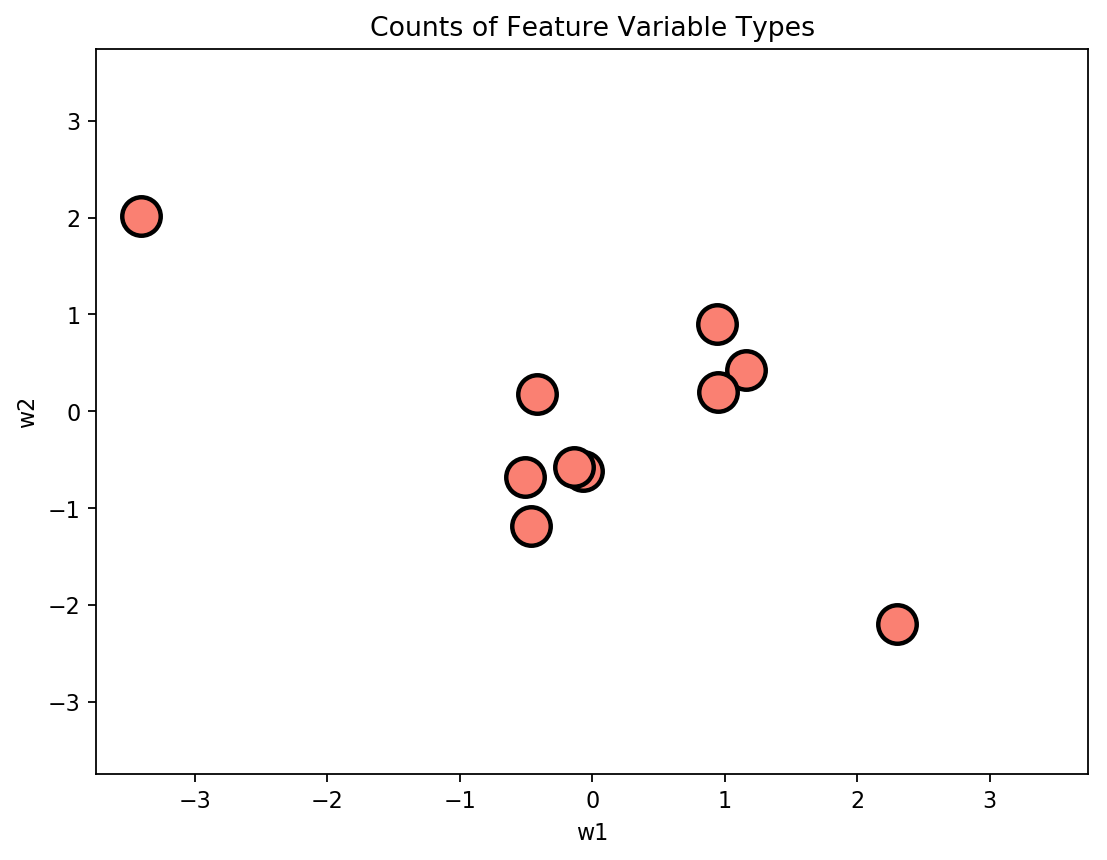

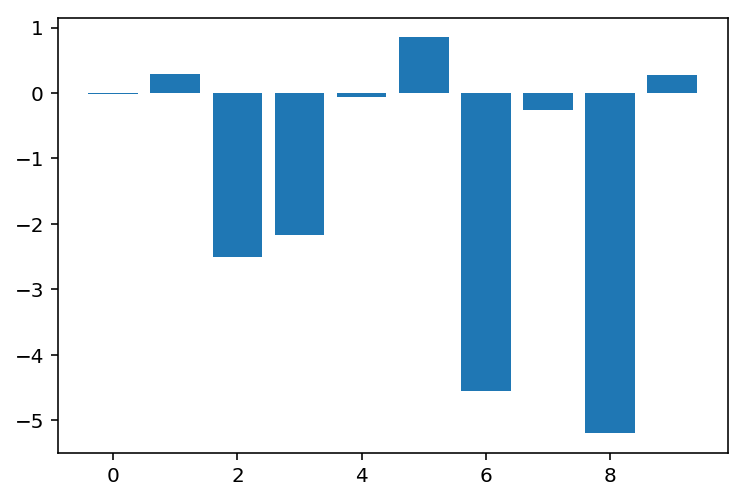

(10,)


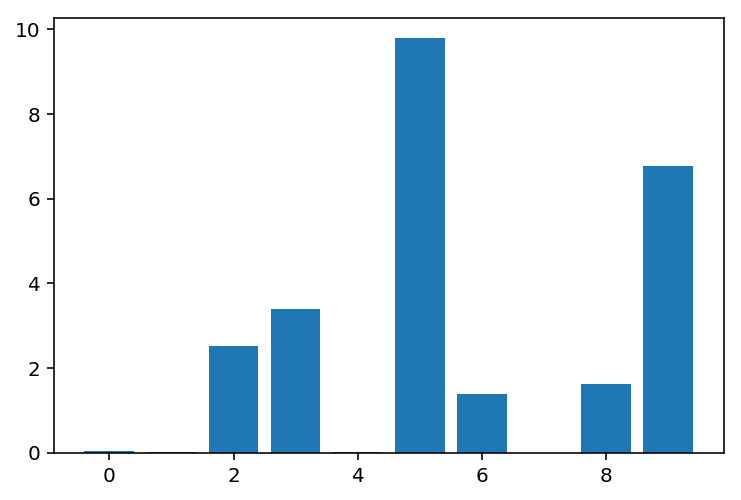

The loss is 0.019855502992868423
40000


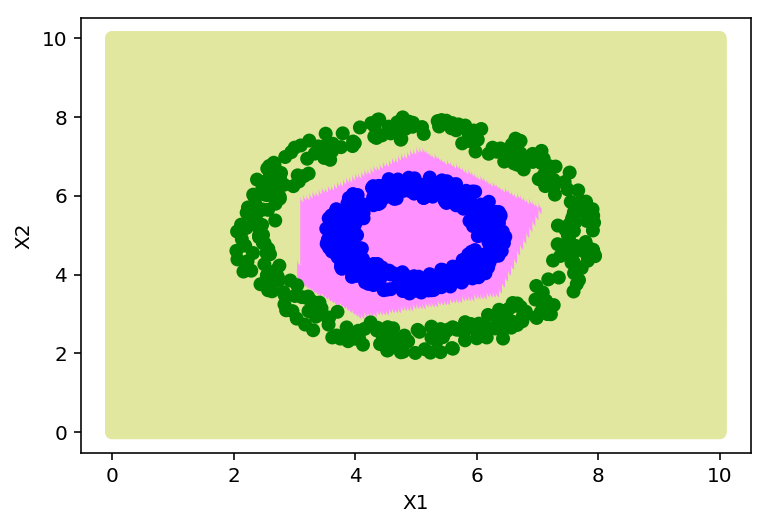

[[ 0.54653955  0.2782563 ]
 [-0.05751055  0.03550518]
 [ 0.61759049  0.7472322 ]
 [ 0.41597012  0.43154588]
 [ 0.41880712 -0.07819523]
 [-0.41727716 -0.66456902]
 [ 0.83243066  1.14416051]
 [ 0.61118579  1.1740427 ]
 [ 0.89836258 -1.9041754 ]
 [-1.90800178  0.43969405]]


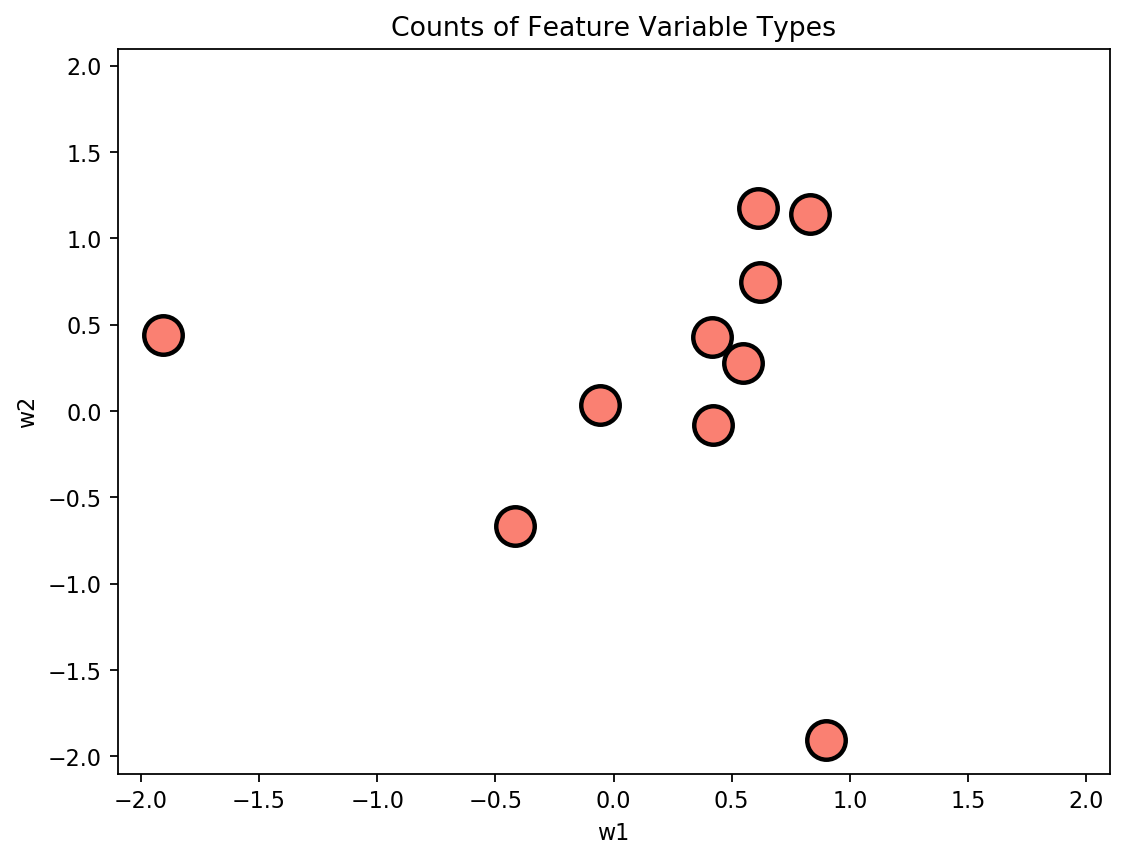

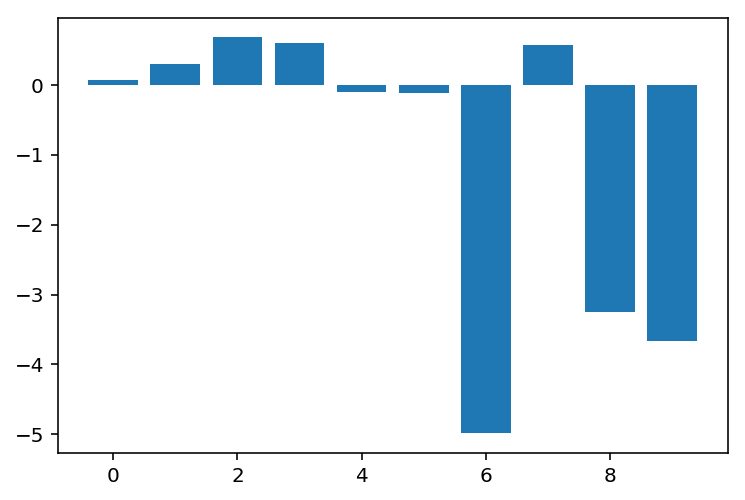

(10,)


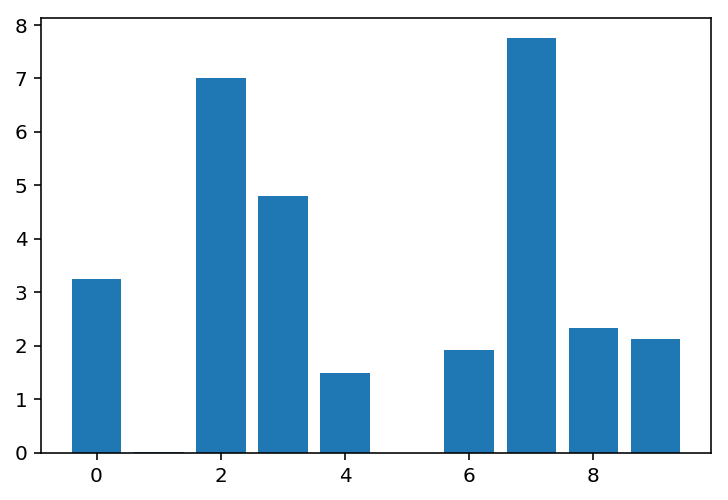

In [120]:
for ind in range(3):

    H = 10
    model = nn.Sequential(nn.Linear(d,H),
                         nn.ReLU(),
                         nn.Linear(H,1),
                          nn.Sigmoid())

    crit = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
    loss = train(x,y,model,crit)
    print("The loss is " + str(loss.tolist()))
    
    o = []

    def hook(module, input, output):
        o.append(output)
    
    model[1].register_forward_hook(hook)
    
    plot_regions(x,y,model)
    show_weights(model)
    a = np.array(o[0].tolist())
    t = np.sum(a, axis=0) / a.shape[0]
    show_layer(t)
    
    


## Data set 2

<Figure size 720x720 with 0 Axes>

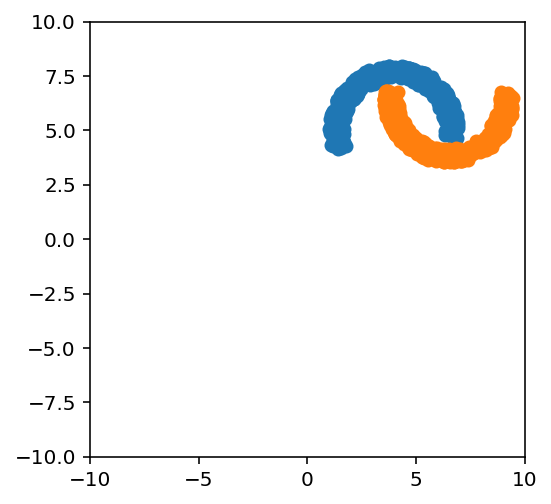

800
800


In [121]:
n = 250
r = 3
x = 5
y = 5

data5 = gen_circle(400, x - 1, y, r, disk_start = .6, circ_start = -.02 , circ_end = .55)
data6 = gen_circle(400, x + 1.5, y + 1.5, r, disk_start = .6, circ_start = .48 , circ_end = 1.02)

plot(data5, data6)

x = torch.FloatTensor(data5 + data6)
y = ([[0]] * len(data5)) + ([[1]] * len(data6))
y = torch.FloatTensor(y)
print(len(x))
print(len(y))

The loss is 0.013176776468753815
40000


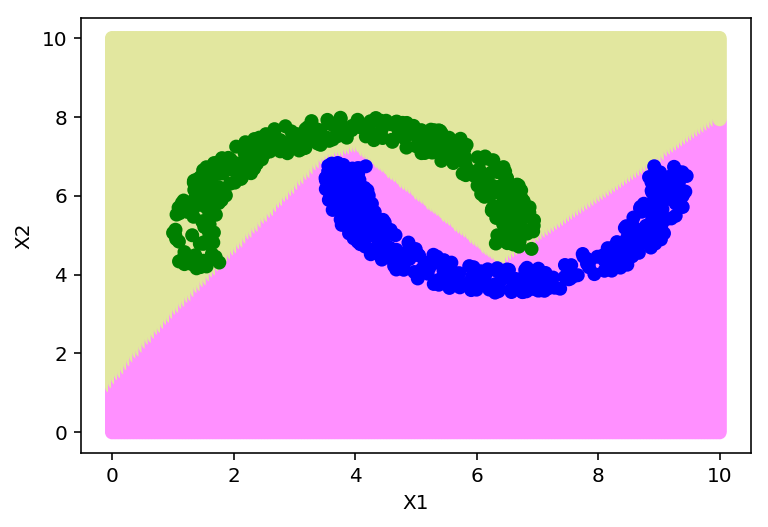

[[ 1.06587958 -0.67954141]
 [-0.43759641 -0.02318921]
 [-0.58488697 -0.44395372]
 [ 1.9692235  -0.69839299]
 [-0.62133902 -0.66463095]
 [ 0.88108742  0.14927606]
 [ 1.00091362 -0.38507769]
 [-0.20734622  0.70132732]
 [ 0.1348505  -0.43805891]
 [-0.15681642 -0.12054771]
 [ 0.53574872 -0.623137  ]
 [-0.4540441  -0.63082612]
 [-0.18668024  0.62424427]
 [-0.66300279 -0.32868725]
 [-0.52327269 -0.5475136 ]
 [ 0.84577835  0.29297483]
 [ 0.68982154  0.26352203]
 [-0.60088593 -0.41451365]
 [-2.49276042  1.02140522]
 [ 0.46642208  0.9434312 ]
 [ 1.524472   -0.04170785]
 [-0.23488429 -0.20962399]
 [-3.54988003  1.81780076]
 [ 0.13801338 -0.43111634]
 [ 1.58092678 -0.20442793]]


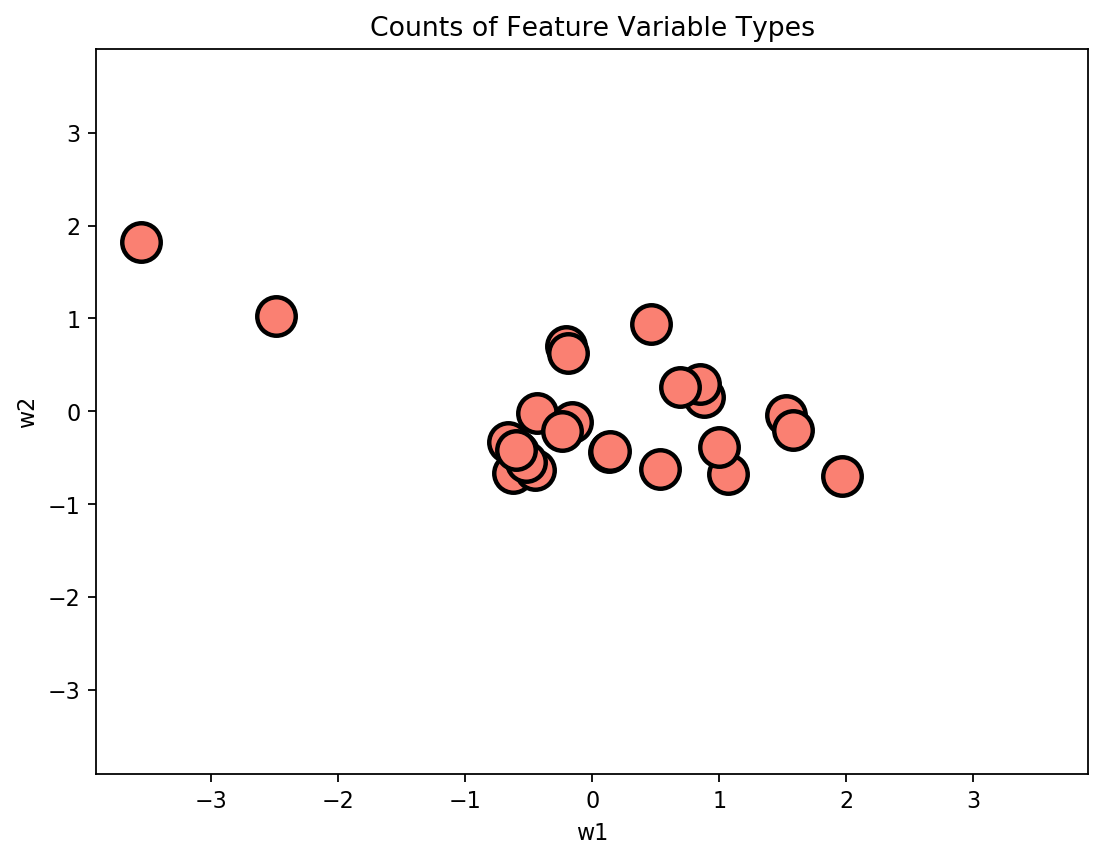

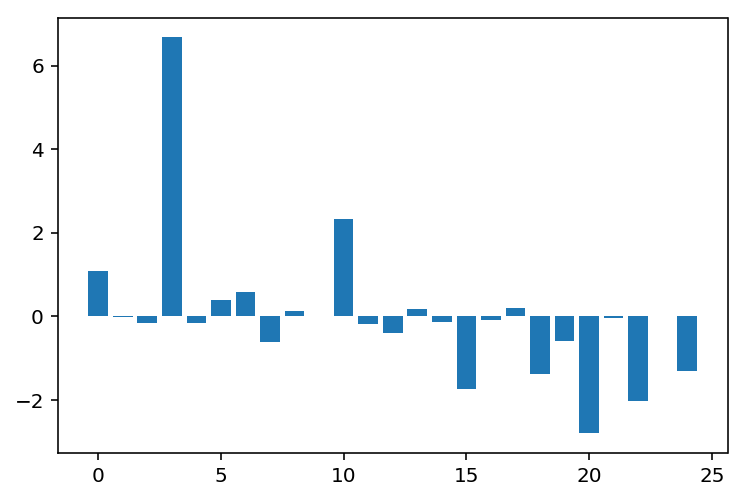

40000


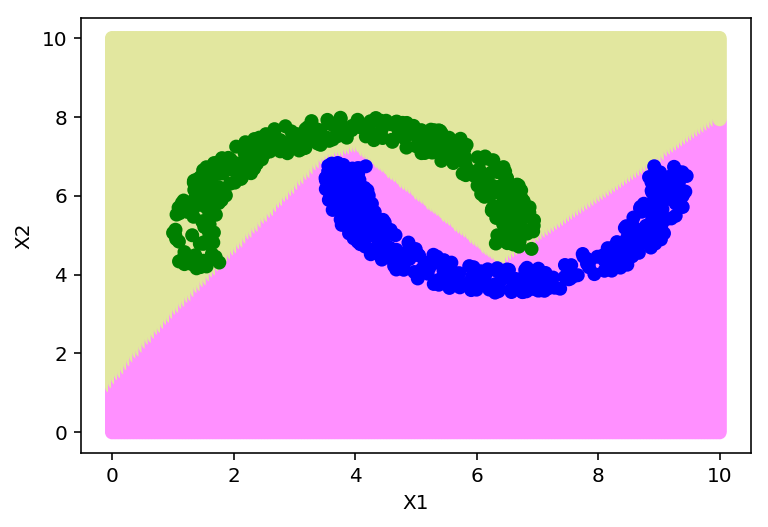

[[ 1.06587958 -0.67954141]
 [-0.43759641 -0.02318921]
 [-0.58488697 -0.44395372]
 [ 1.9692235  -0.69839299]
 [-0.62133902 -0.66463095]
 [ 0.88108742  0.14927606]
 [ 1.00091362 -0.38507769]
 [-0.20734622  0.70132732]
 [ 0.1348505  -0.43805891]
 [-0.15681642 -0.12054771]
 [ 0.53574872 -0.623137  ]
 [-0.4540441  -0.63082612]
 [-0.18668024  0.62424427]
 [-0.66300279 -0.32868725]
 [-0.52327269 -0.5475136 ]
 [ 0.84577835  0.29297483]
 [ 0.68982154  0.26352203]
 [-0.60088593 -0.41451365]
 [-2.49276042  1.02140522]
 [ 0.46642208  0.9434312 ]
 [ 1.524472   -0.04170785]
 [-0.23488429 -0.20962399]
 [-3.54988003  1.81780076]
 [ 0.13801338 -0.43111634]
 [ 1.58092678 -0.20442793]]


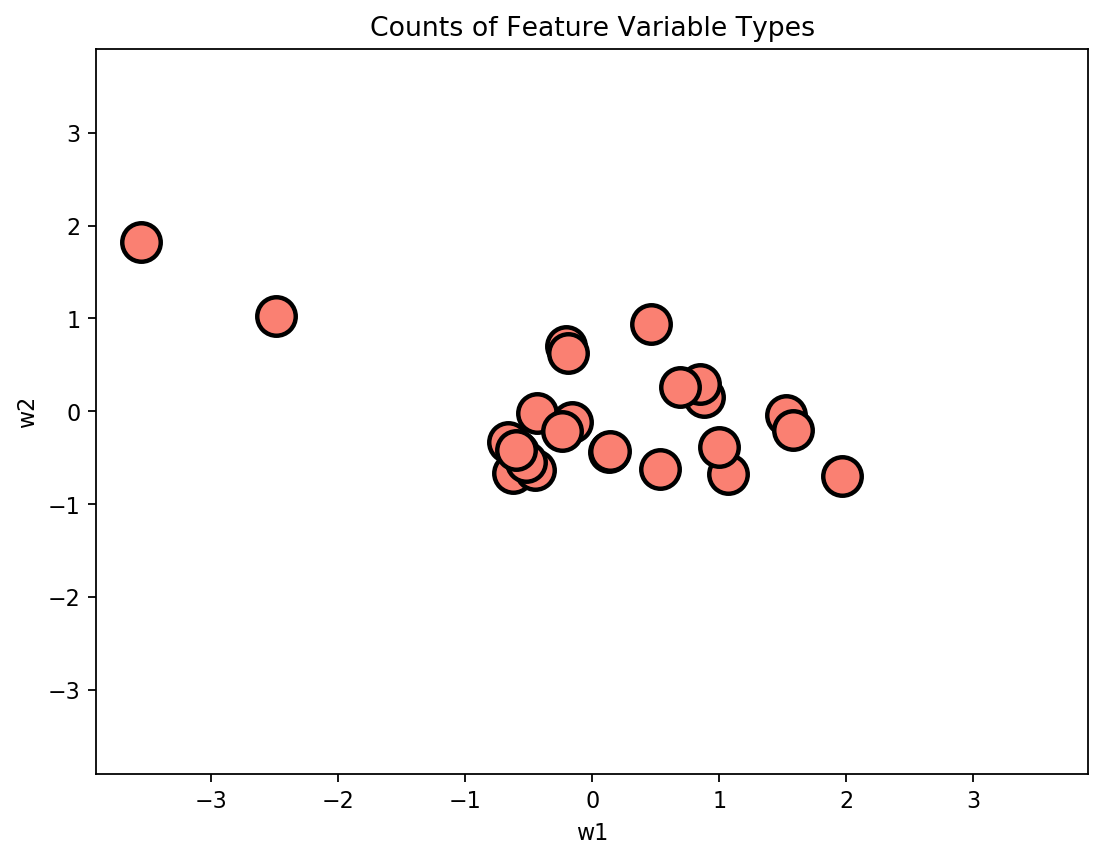

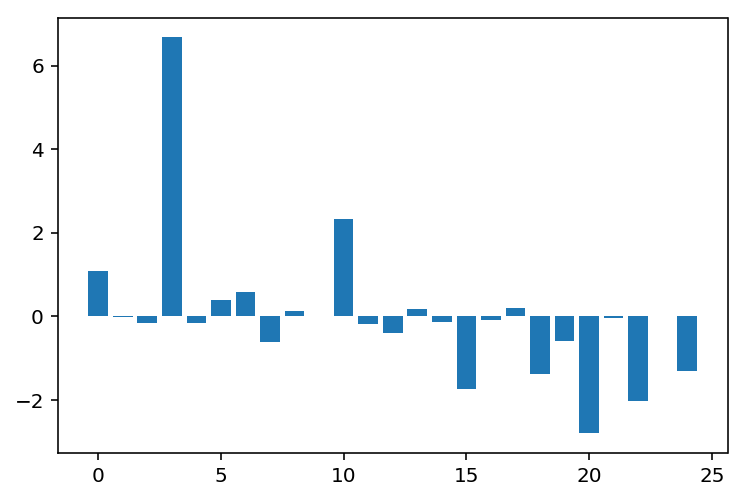

(25,)


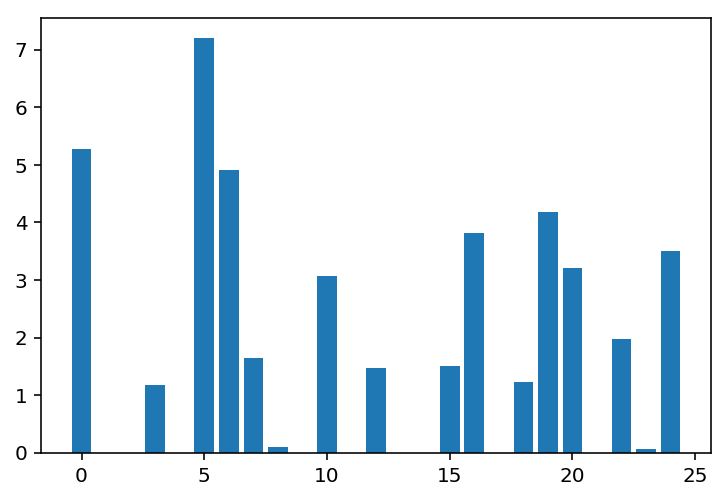

The loss is 0.30525514483451843
40000


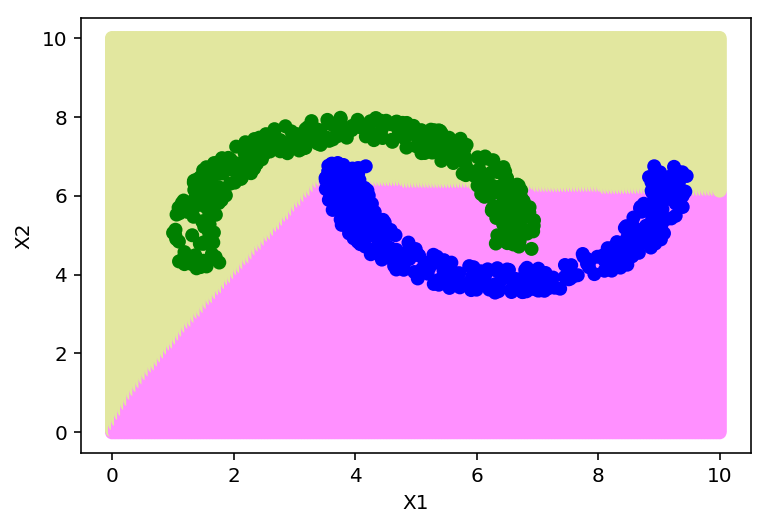

[[ 1.44864249e+00 -2.37474188e-01]
 [ 2.68545955e-01 -2.74454039e-02]
 [-3.75516206e-01 -4.58103716e-01]
 [-5.90452790e-01  1.64925098e-01]
 [-1.62985891e-01  4.68734801e-01]
 [-1.37519166e-01  9.39987600e-01]
 [ 7.72615016e-01 -2.17912316e-01]
 [-6.13298595e-01  2.17562914e-03]
 [-9.66789722e-02 -6.24552131e-01]
 [-3.07041585e-01  7.86436856e-01]
 [ 2.33889341e-01 -5.51347077e-01]
 [-9.49756503e-02 -4.72223222e-01]
 [ 1.50392950e-01 -3.62425983e-01]
 [-1.98078975e-01  9.34551597e-01]
 [-2.40566111e+00  9.57319677e-01]
 [ 6.47468448e-01 -3.90997052e-01]
 [ 1.55753434e-01 -6.35523558e-01]
 [-2.24749148e-01 -1.17945015e-01]
 [ 5.89521945e-01 -1.71164349e-01]
 [ 7.60007873e-02  4.47480440e-01]
 [-5.18348753e-01 -6.55685484e-01]
 [ 5.33770859e-01  4.42489237e-01]
 [-3.73079091e-01  5.96931577e-02]
 [ 5.61509728e-01  2.71291912e-01]
 [ 2.60759532e-01  3.20889801e-01]]


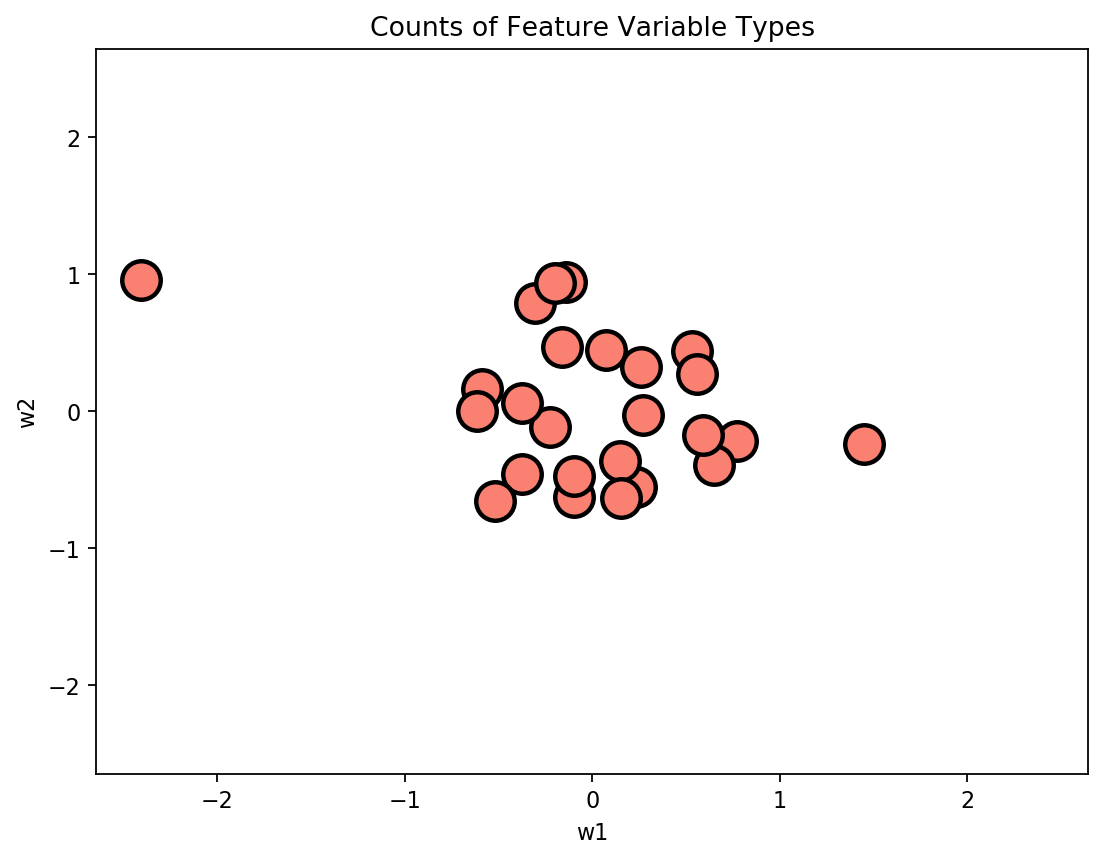

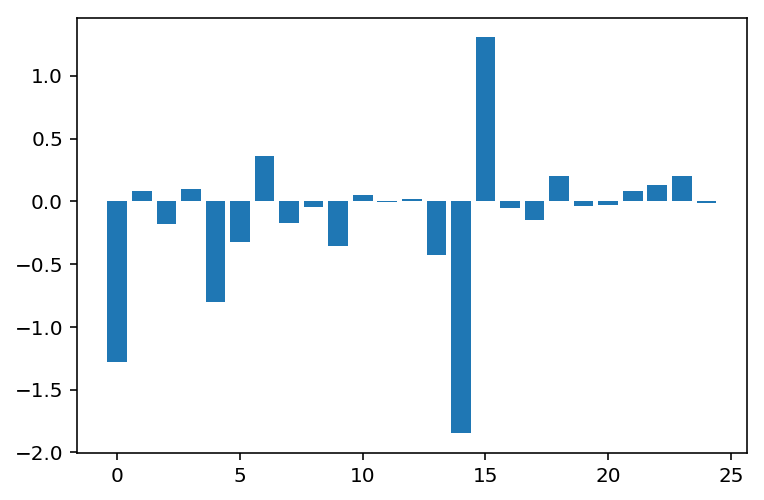

40000


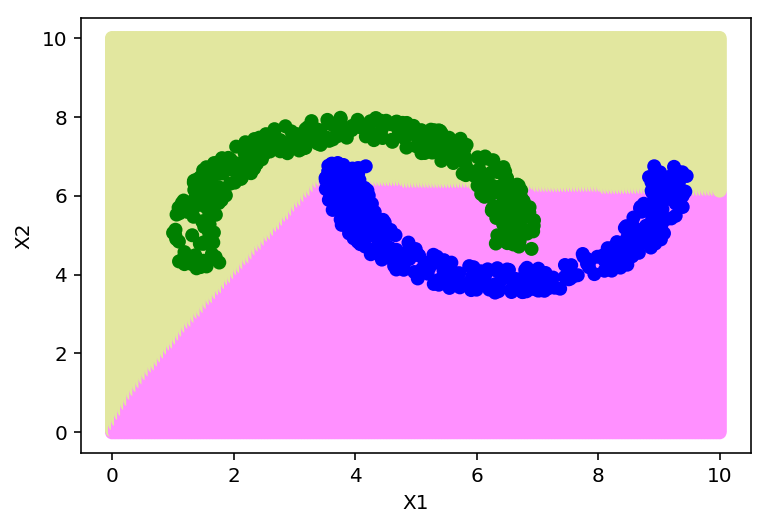

[[ 1.44864249e+00 -2.37474188e-01]
 [ 2.68545955e-01 -2.74454039e-02]
 [-3.75516206e-01 -4.58103716e-01]
 [-5.90452790e-01  1.64925098e-01]
 [-1.62985891e-01  4.68734801e-01]
 [-1.37519166e-01  9.39987600e-01]
 [ 7.72615016e-01 -2.17912316e-01]
 [-6.13298595e-01  2.17562914e-03]
 [-9.66789722e-02 -6.24552131e-01]
 [-3.07041585e-01  7.86436856e-01]
 [ 2.33889341e-01 -5.51347077e-01]
 [-9.49756503e-02 -4.72223222e-01]
 [ 1.50392950e-01 -3.62425983e-01]
 [-1.98078975e-01  9.34551597e-01]
 [-2.40566111e+00  9.57319677e-01]
 [ 6.47468448e-01 -3.90997052e-01]
 [ 1.55753434e-01 -6.35523558e-01]
 [-2.24749148e-01 -1.17945015e-01]
 [ 5.89521945e-01 -1.71164349e-01]
 [ 7.60007873e-02  4.47480440e-01]
 [-5.18348753e-01 -6.55685484e-01]
 [ 5.33770859e-01  4.42489237e-01]
 [-3.73079091e-01  5.96931577e-02]
 [ 5.61509728e-01  2.71291912e-01]
 [ 2.60759532e-01  3.20889801e-01]]


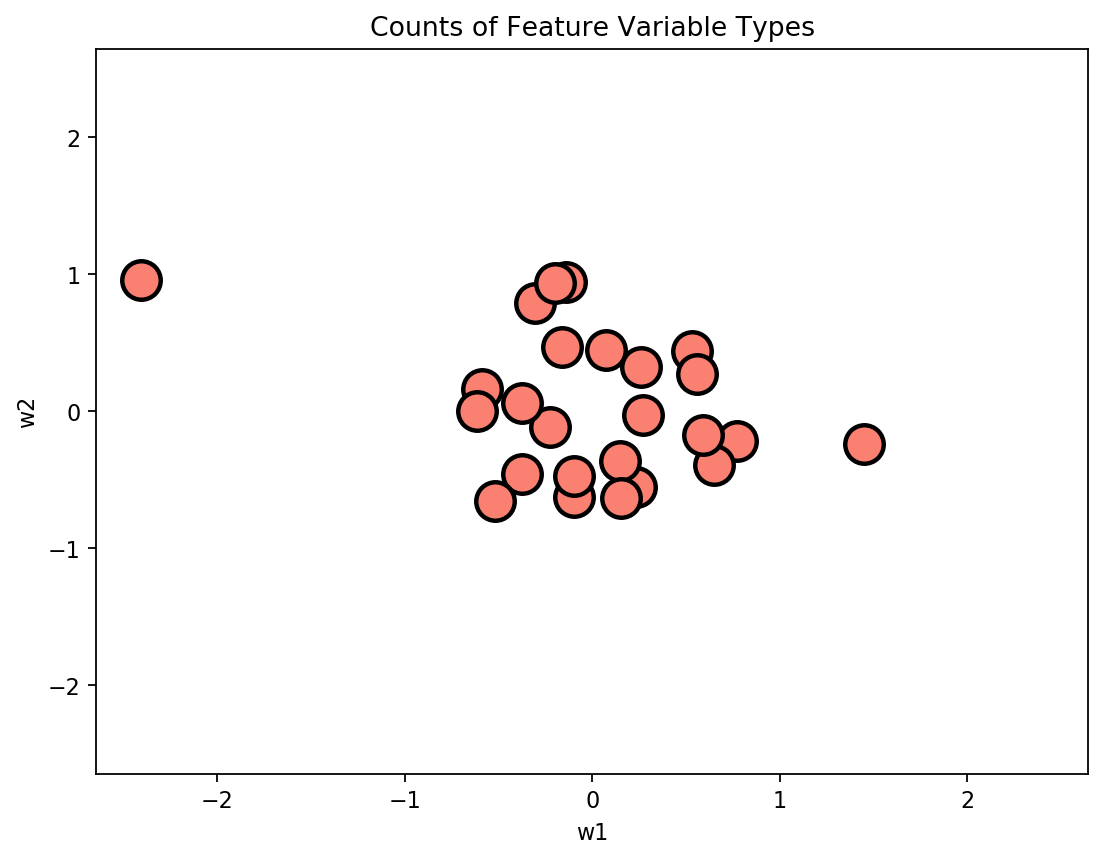

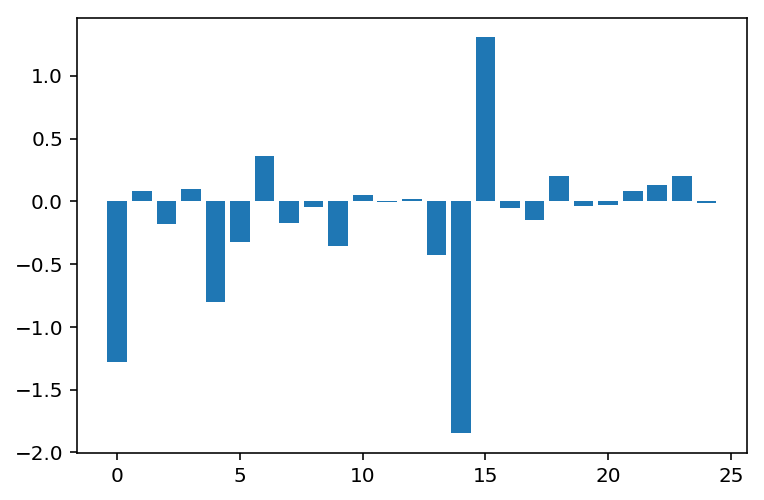

(25,)


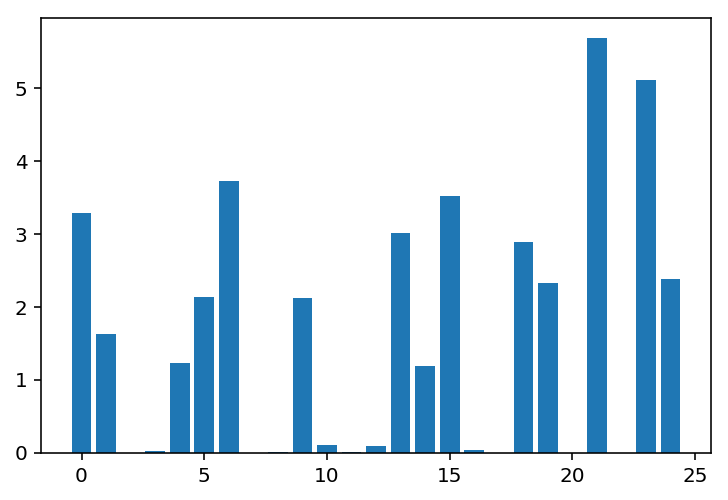

The loss is 0.0140629718080163
40000


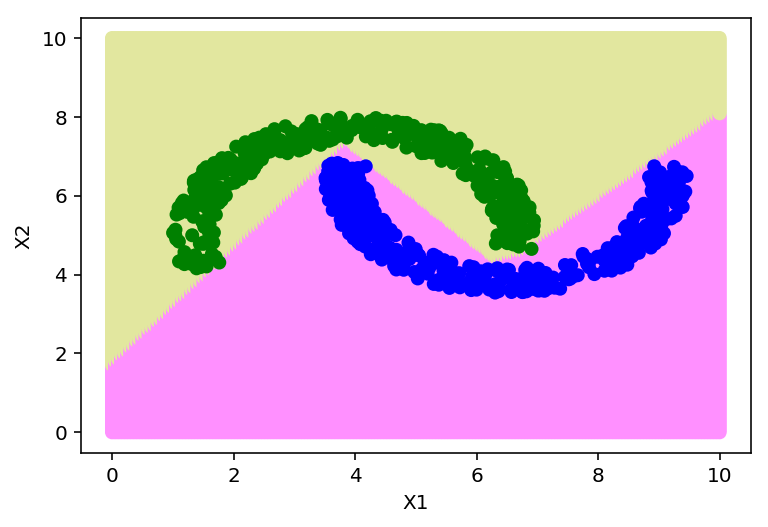

[[-0.40910429  0.11275202]
 [ 0.19851249 -0.67048526]
 [-0.12883055 -0.41724005]
 [ 0.13390863 -0.32318777]
 [-0.14163953 -0.08983088]
 [ 1.44133258 -0.61407495]
 [-0.04285425 -0.20572346]
 [ 0.17167008 -0.43800092]
 [ 4.29830742 -1.32104981]
 [ 2.00405908 -0.58298737]
 [ 1.61318552 -0.69328606]
 [ 0.13744795 -0.56309104]
 [-0.03570503 -0.59260219]
 [-0.63042212  1.46670043]
 [-0.53848577 -0.49051091]
 [ 1.71706116 -1.0804019 ]
 [-0.27840295 -0.2762413 ]
 [-0.75254601  1.79877853]
 [-0.5963313  -0.42286119]
 [-0.6609934  -0.25882488]
 [-0.55539322 -0.07230234]
 [ 1.7186904  -0.81730115]
 [ 2.47191668 -0.9567852 ]
 [ 1.18253112  0.07195186]
 [-0.64944983  1.0973736 ]]


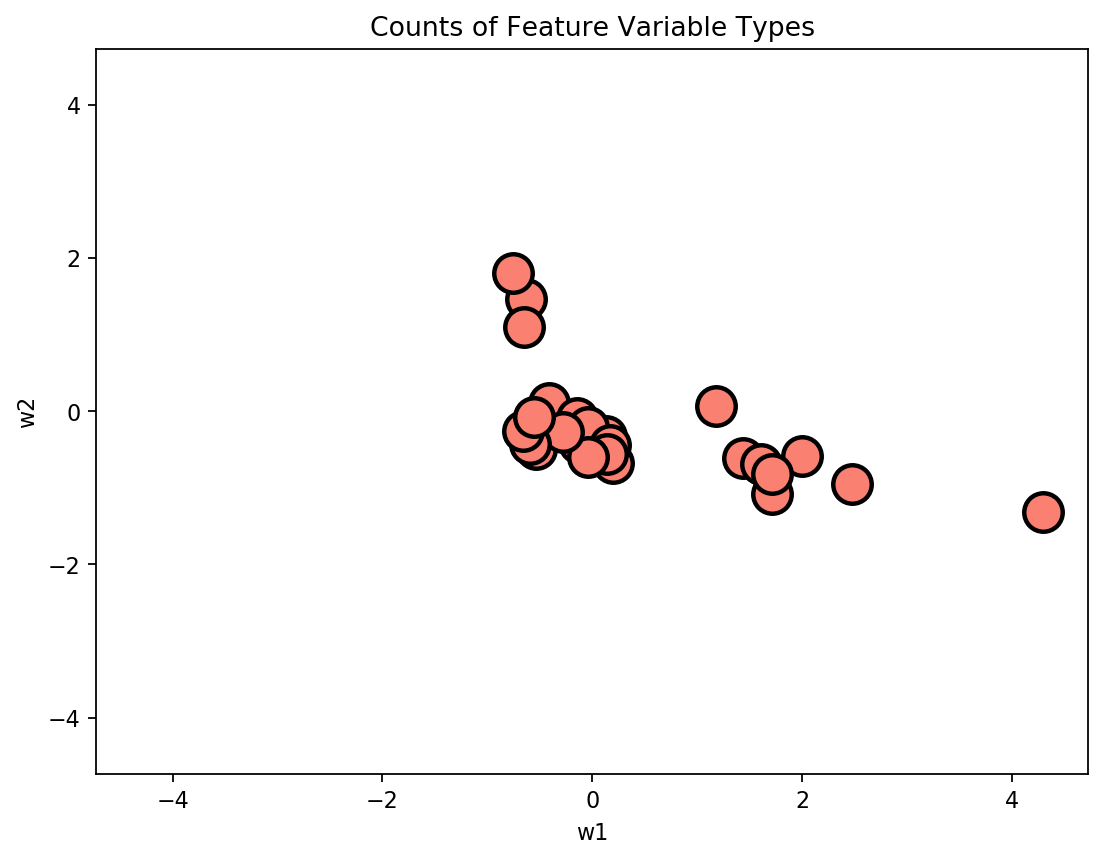

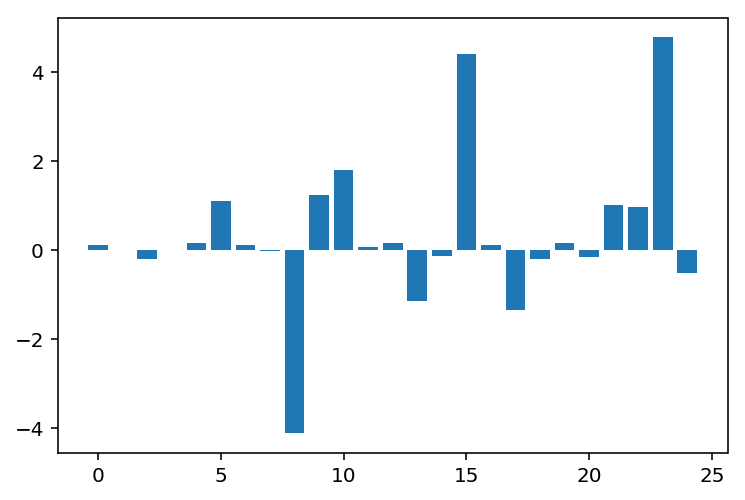

40000


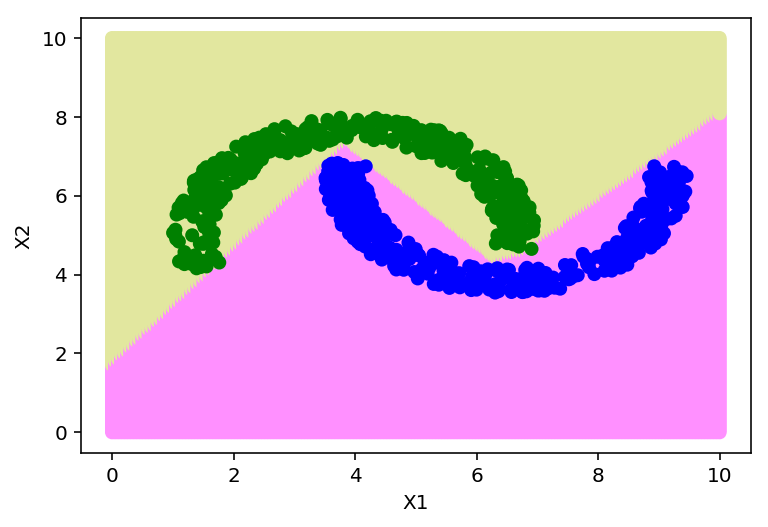

[[-0.40910429  0.11275202]
 [ 0.19851249 -0.67048526]
 [-0.12883055 -0.41724005]
 [ 0.13390863 -0.32318777]
 [-0.14163953 -0.08983088]
 [ 1.44133258 -0.61407495]
 [-0.04285425 -0.20572346]
 [ 0.17167008 -0.43800092]
 [ 4.29830742 -1.32104981]
 [ 2.00405908 -0.58298737]
 [ 1.61318552 -0.69328606]
 [ 0.13744795 -0.56309104]
 [-0.03570503 -0.59260219]
 [-0.63042212  1.46670043]
 [-0.53848577 -0.49051091]
 [ 1.71706116 -1.0804019 ]
 [-0.27840295 -0.2762413 ]
 [-0.75254601  1.79877853]
 [-0.5963313  -0.42286119]
 [-0.6609934  -0.25882488]
 [-0.55539322 -0.07230234]
 [ 1.7186904  -0.81730115]
 [ 2.47191668 -0.9567852 ]
 [ 1.18253112  0.07195186]
 [-0.64944983  1.0973736 ]]


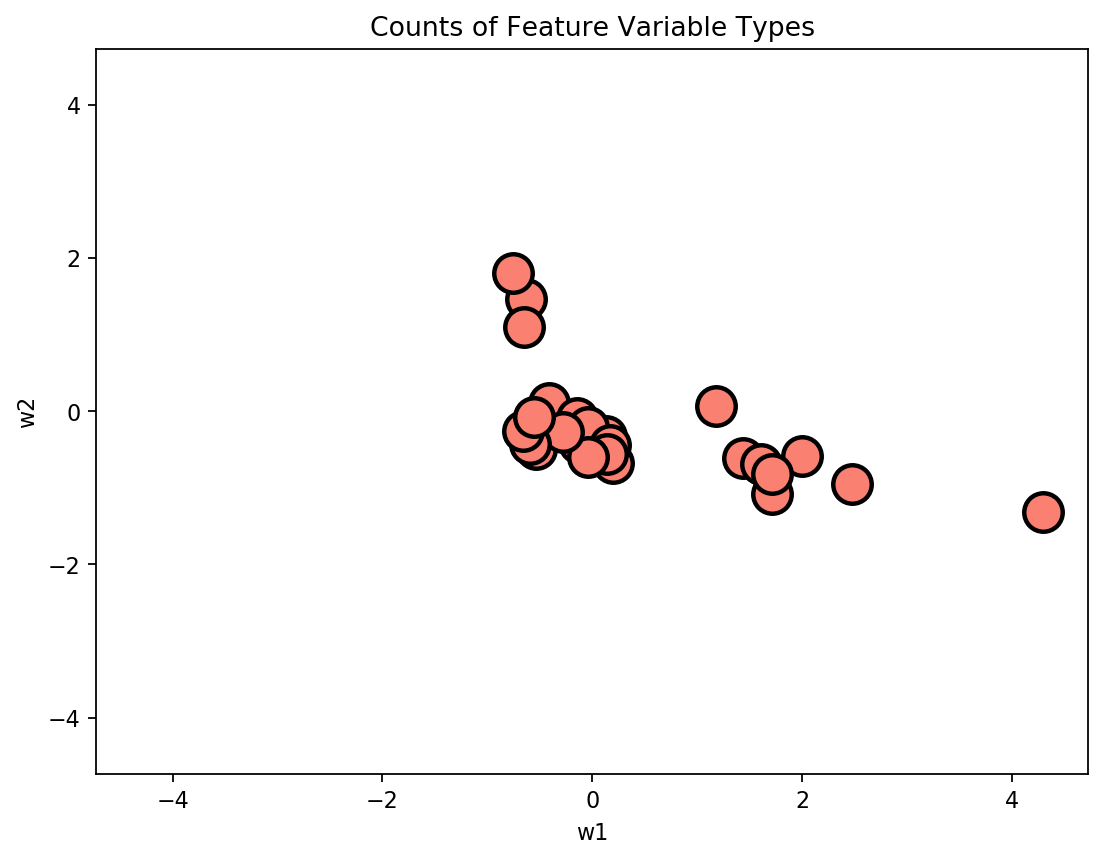

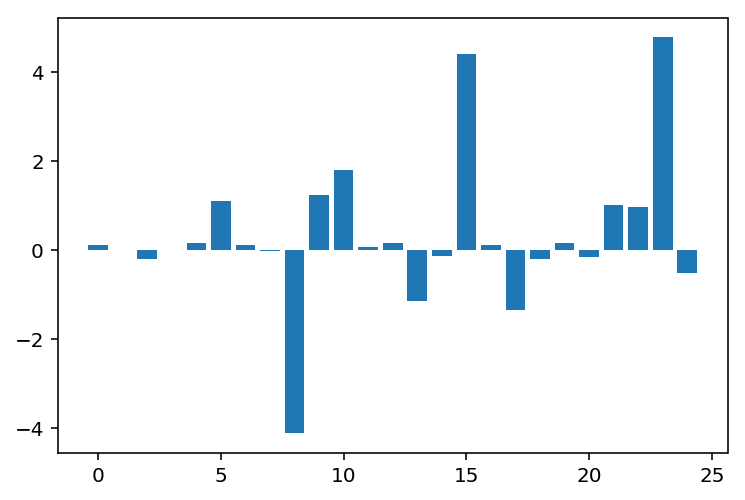

(25,)


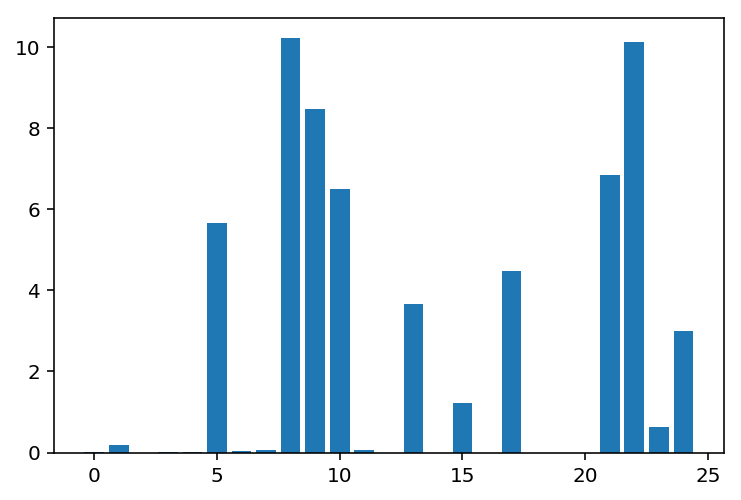

In [122]:
for ind in range(3):

    H = 25
    model = nn.Sequential(nn.Linear(d,H),
                         nn.ReLU(),
                         nn.Linear(H,1),
                          nn.Sigmoid())

    crit = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
    loss = train(x,y,model,crit)
    print("The loss is " + str(loss.tolist()))
    
        
    o = []

    def hook(module, input, output):
        o.append(output)
    
    model[1].register_forward_hook(hook)
    
    plot_regions(x,y,model)
    show_weights(model)
    a = np.array(o[0].tolist())
    t = np.sum(a, axis=0) / a.shape[0]
    
    
    plot_regions(x,y,model)
    show_weights(model)
    show_layer(t)


## Data Set 3

---------------------------------------------------------------
The loss is 0.001421634224243462
40000


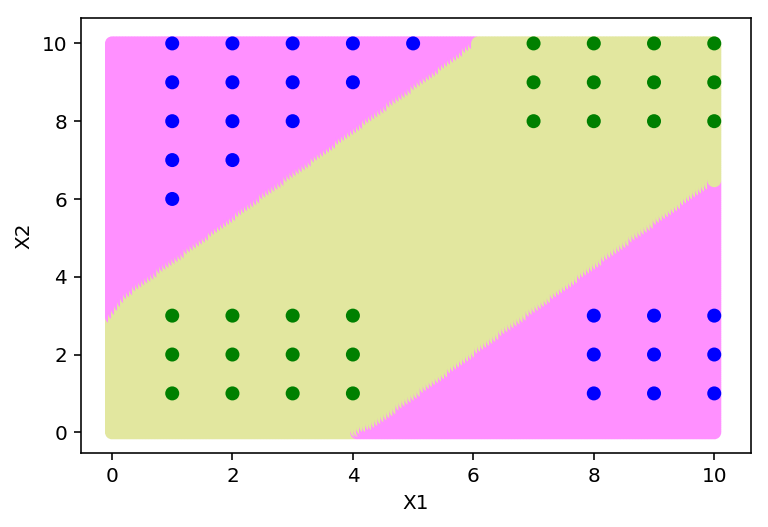

[[-2.6236186   2.2194314 ]
 [-0.4697932  -0.23822653]
 [ 0.86731362  1.07536435]
 [ 1.40418935  0.42179853]
 [ 2.11655807 -1.98318458]]


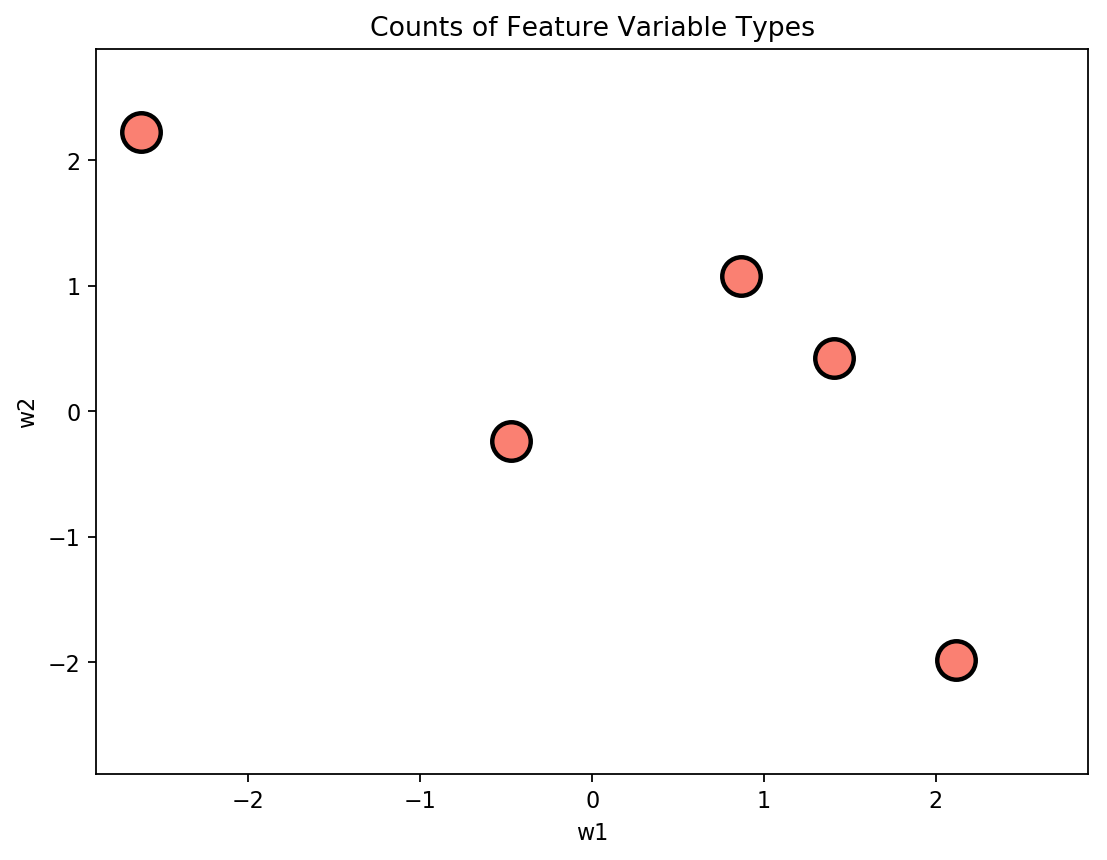

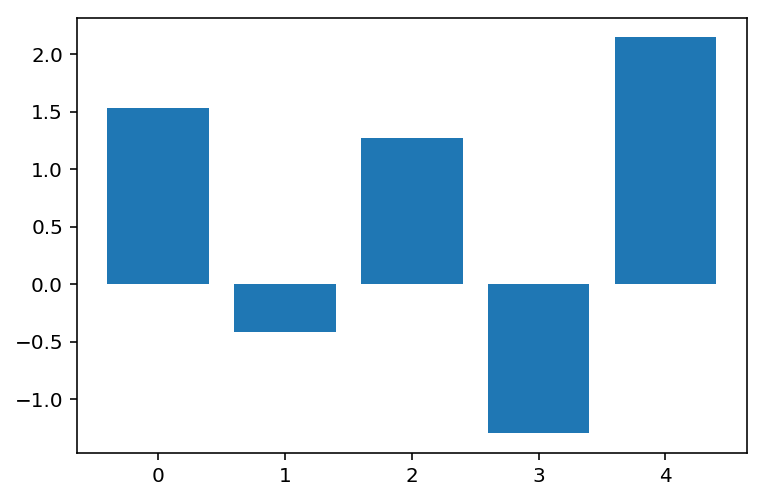

(5,)


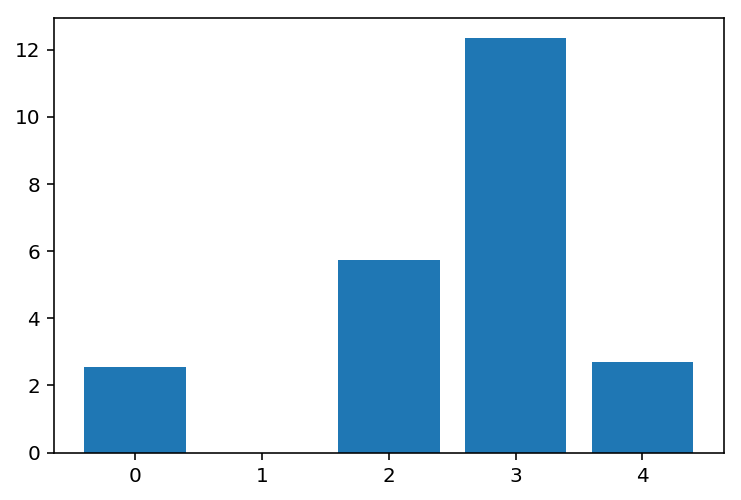

---------------------------------------------------------------
---------------------------------------------------------------
The loss is 0.0023593311198055744
40000


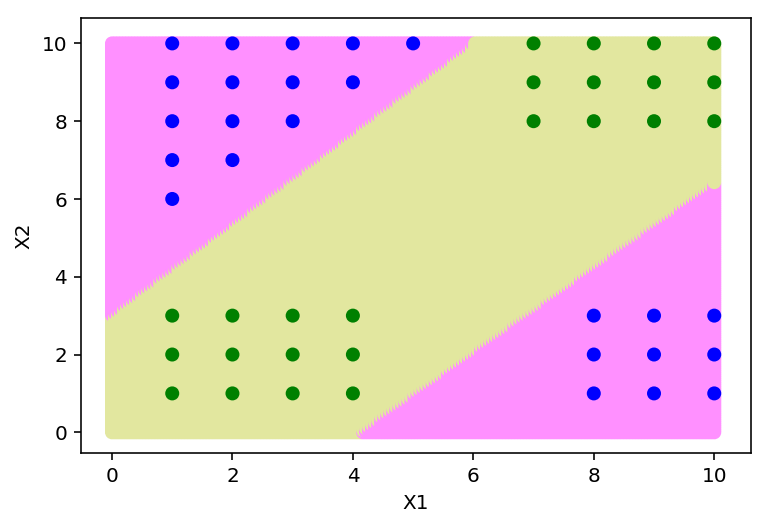

[[ 0.01438957 -0.55375421]
 [ 0.20569998  0.05134296]
 [-0.6846863  -0.44678155]
 [-1.74497318  1.62246752]
 [ 1.71067977 -1.41347575]]


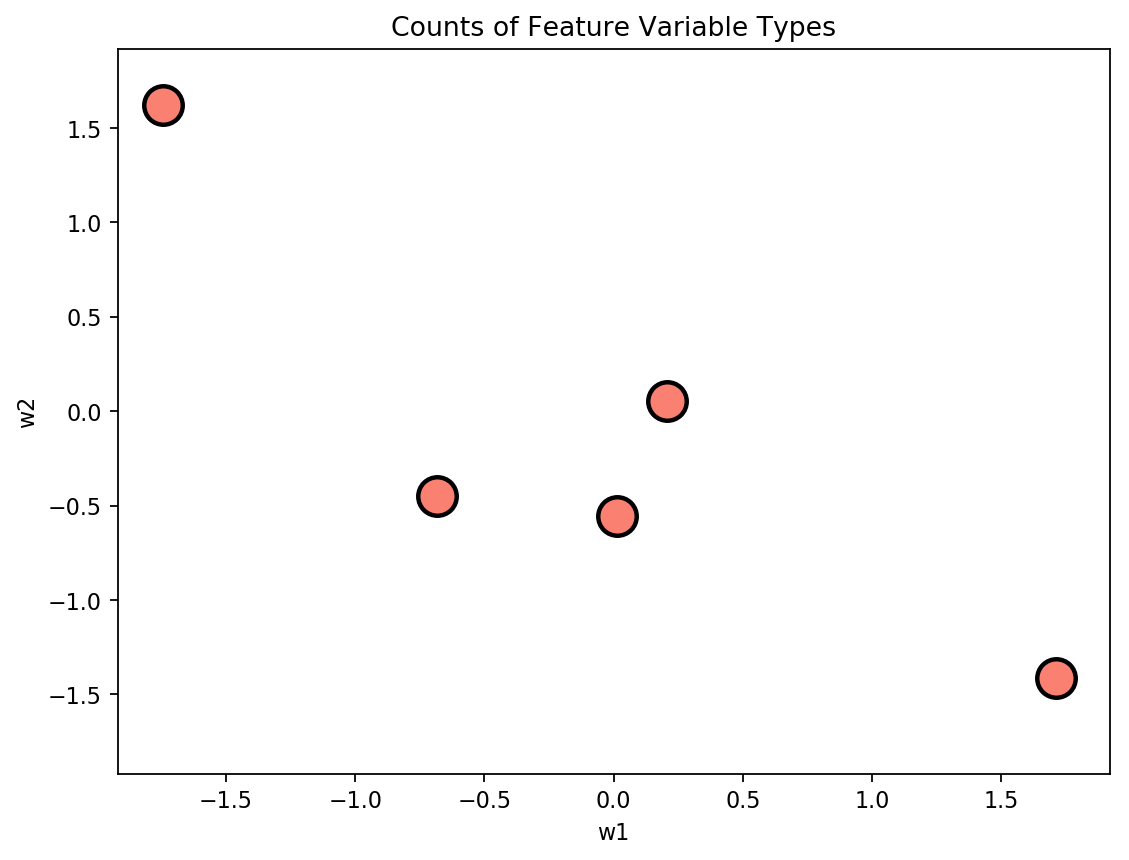

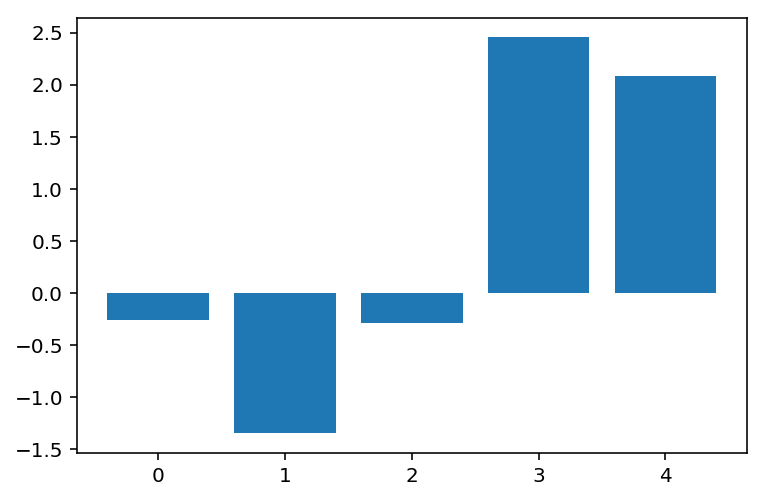

(5,)


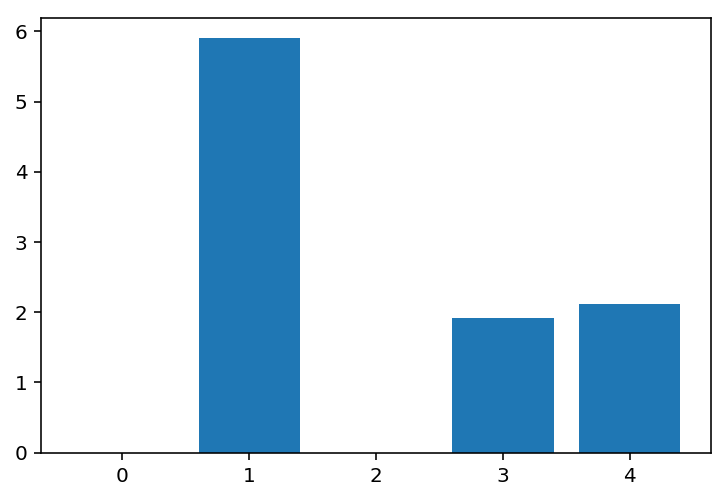

---------------------------------------------------------------
---------------------------------------------------------------
The loss is 0.006868903059512377
40000


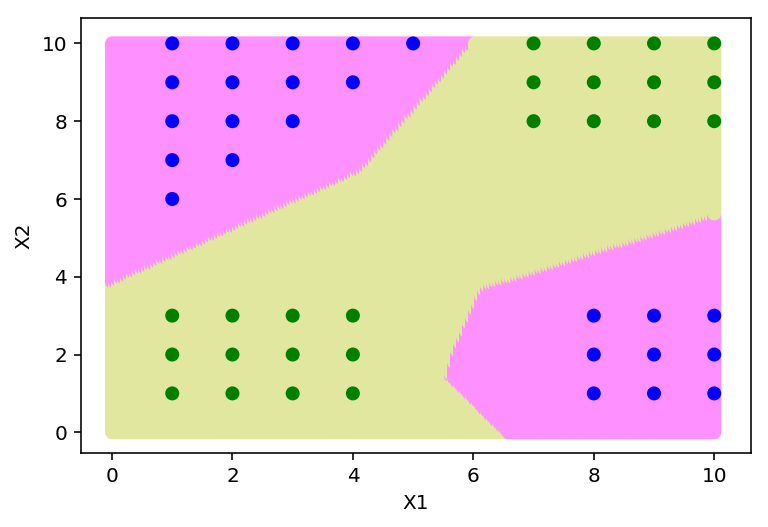

[[-2.03443313  1.6911186 ]
 [-0.44521081 -0.29112238]
 [-0.27454093 -0.70676678]
 [-0.28031334  0.69290388]
 [-0.75225794  1.48328948]]


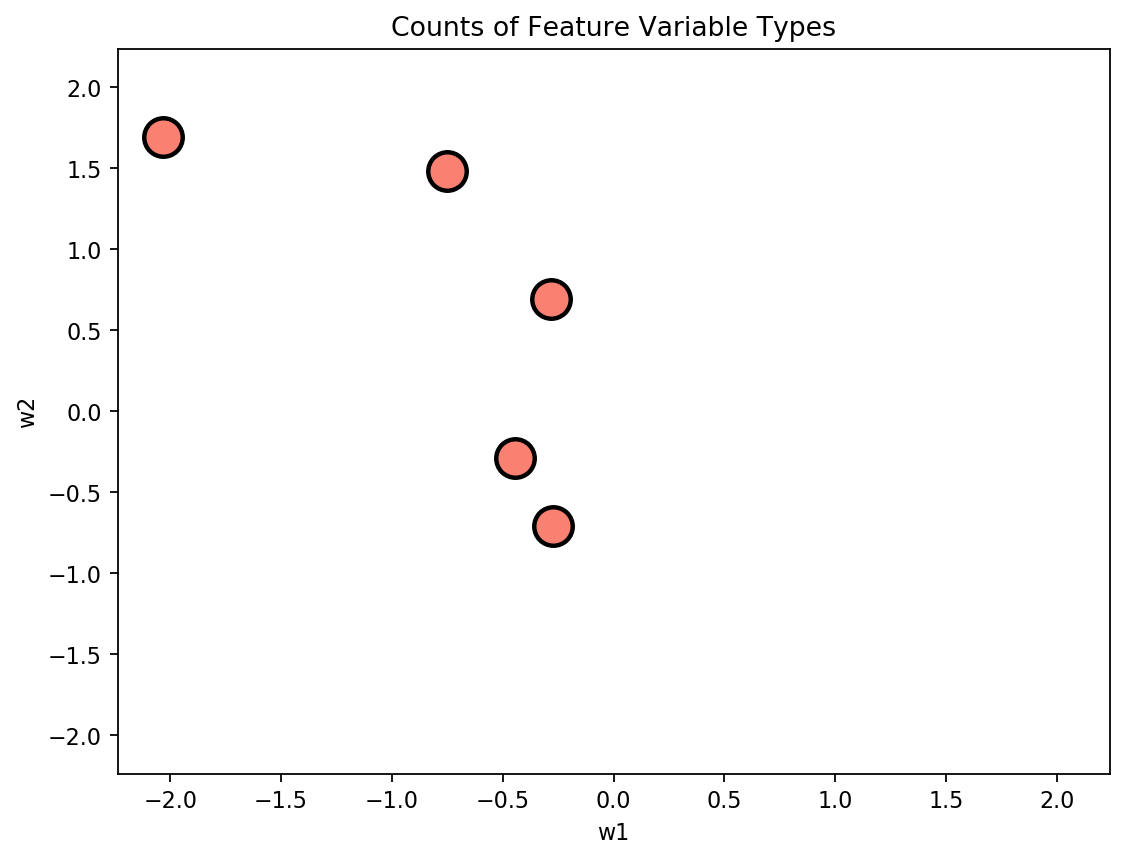

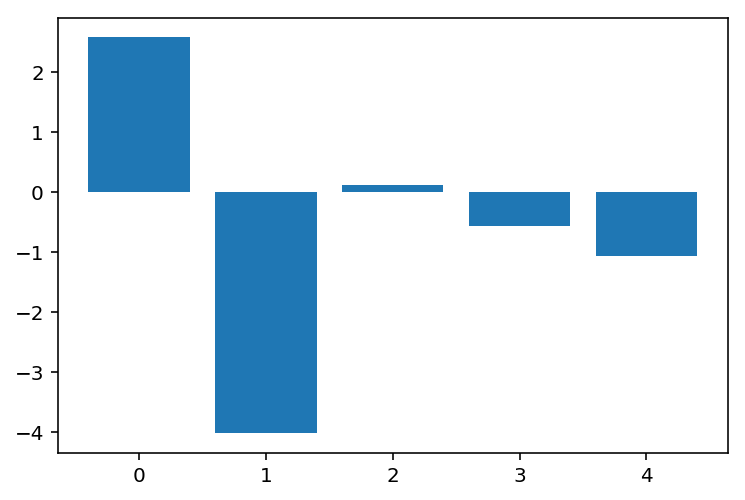

(5,)


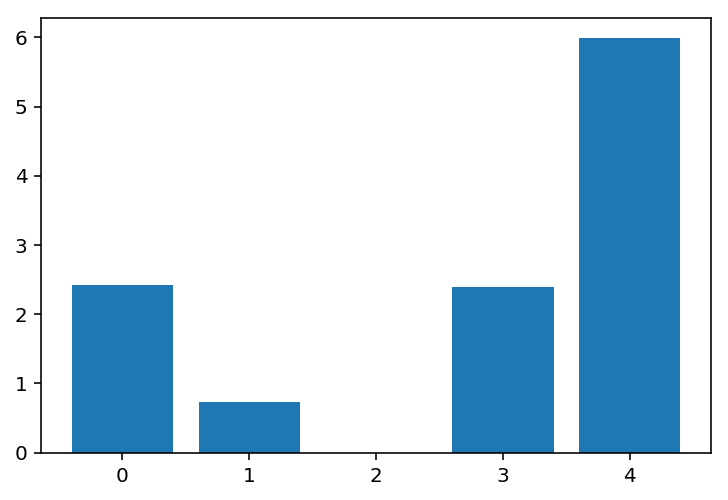

---------------------------------------------------------------


In [123]:

x,y = load_data('data0.txt')
x = torch.FloatTensor(x)
y = torch.FloatTensor(y)
for ind in range(3):
    print('---------------------------------------------------------------')
    H = 5
    model = nn.Sequential(nn.Linear(d,H),
                         nn.ReLU(),
                         nn.Linear(H,1),
                          nn.Sigmoid())

    crit = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
    loss = train(x,y,model,crit)
    print("The loss is " + str(loss.tolist()))
           
    o = []

    def hook(module, input, output):
        o.append(output)
    
    model[1].register_forward_hook(hook)
    
    plot_regions(x,y,model)
    show_weights(model)
    a = np.array(o[0].tolist())
    t = np.sum(a, axis=0) / a.shape[0]
    
    
    
    
    #plot_regions(x,y,model)
    #show_weights(model)
    show_layer(t)
    print('---------------------------------------------------------------')

## Data Set 4

The loss is 0.43319448828697205
40000


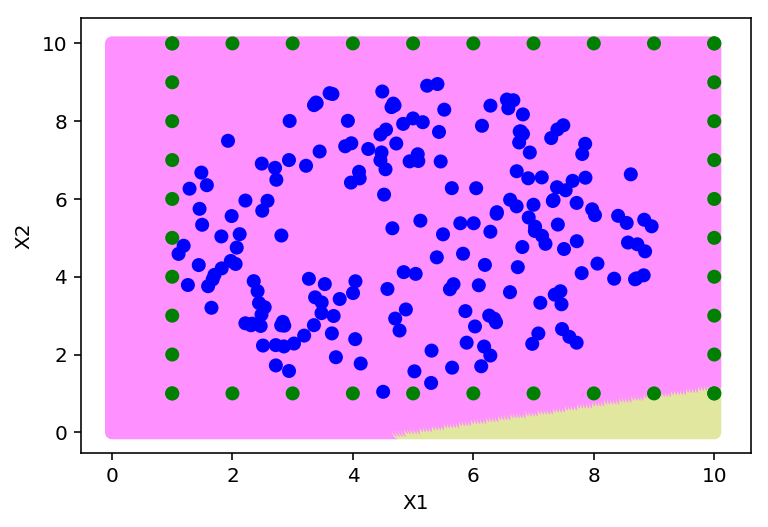

[[ 0.64252716 -0.06198345]
 [ 0.16874482  0.6422016 ]
 [ 0.09384702 -0.06001854]
 [ 0.49291724 -0.71033484]
 [-0.47942823 -0.68689305]]


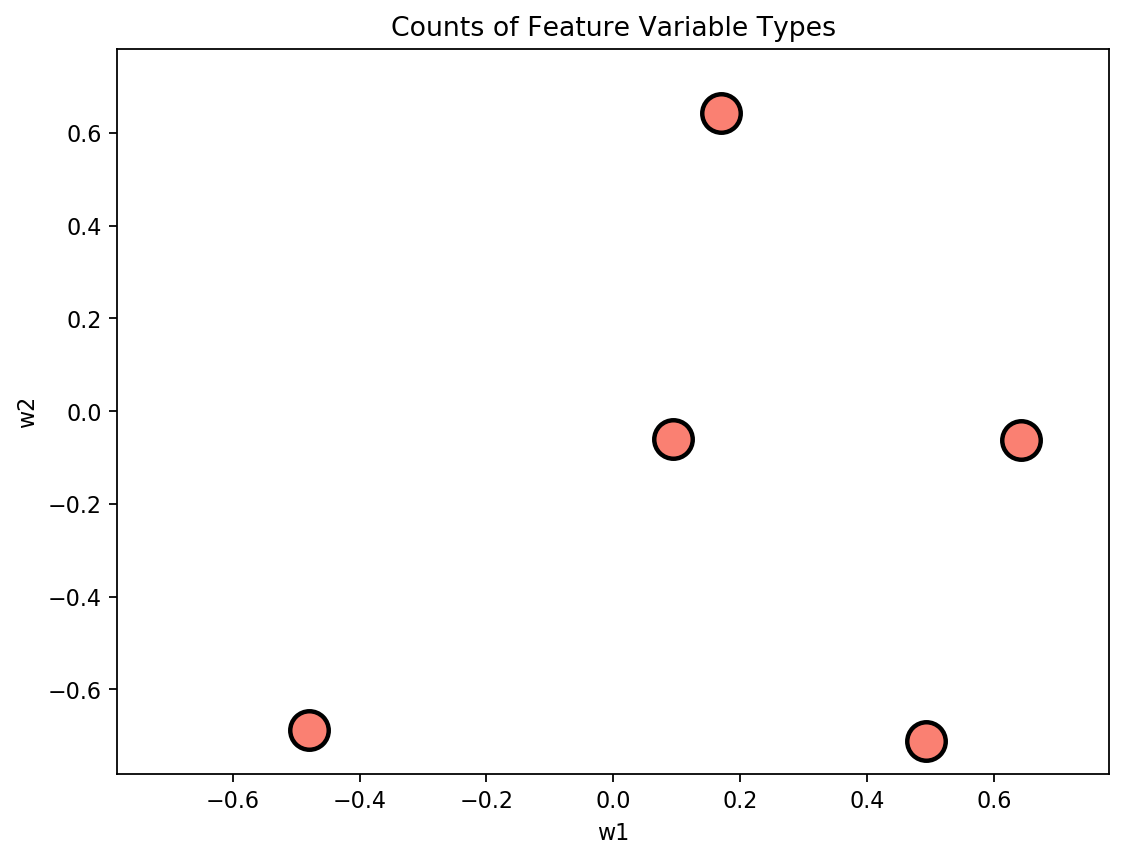

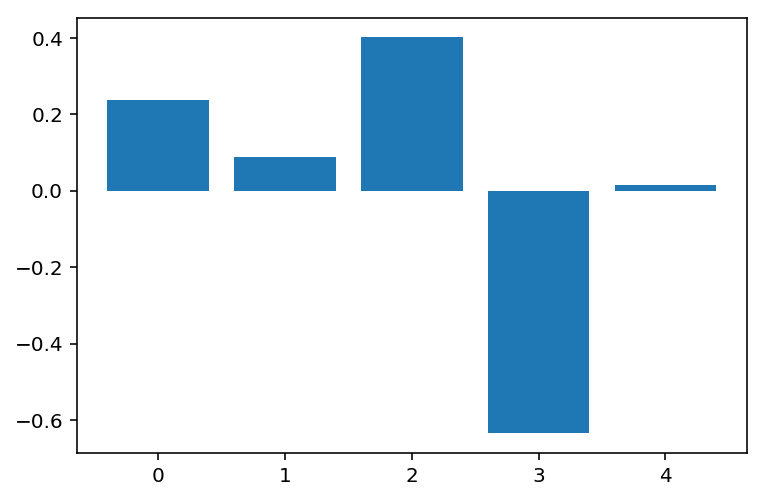

The loss is 0.4113427996635437
40000


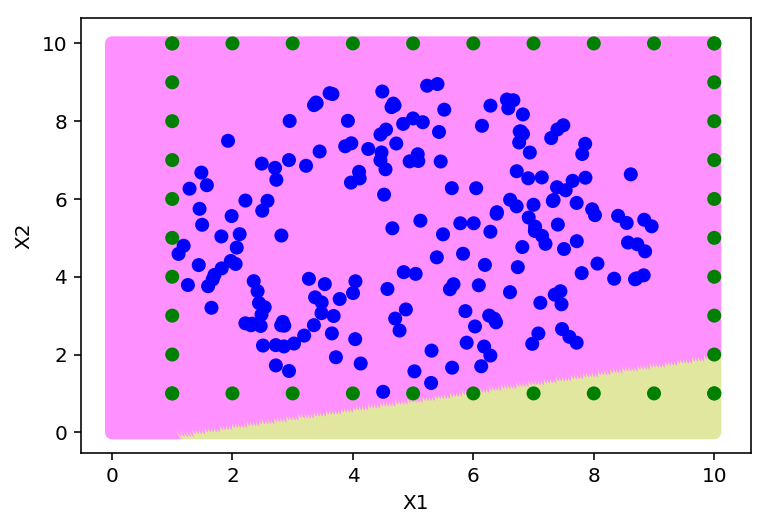

[[ 0.5421626  -0.84838915]
 [ 0.21100157  0.50039965]
 [ 0.66725248 -0.55225998]
 [-0.25521594  0.56658572]
 [-0.64403743  0.12840477]]


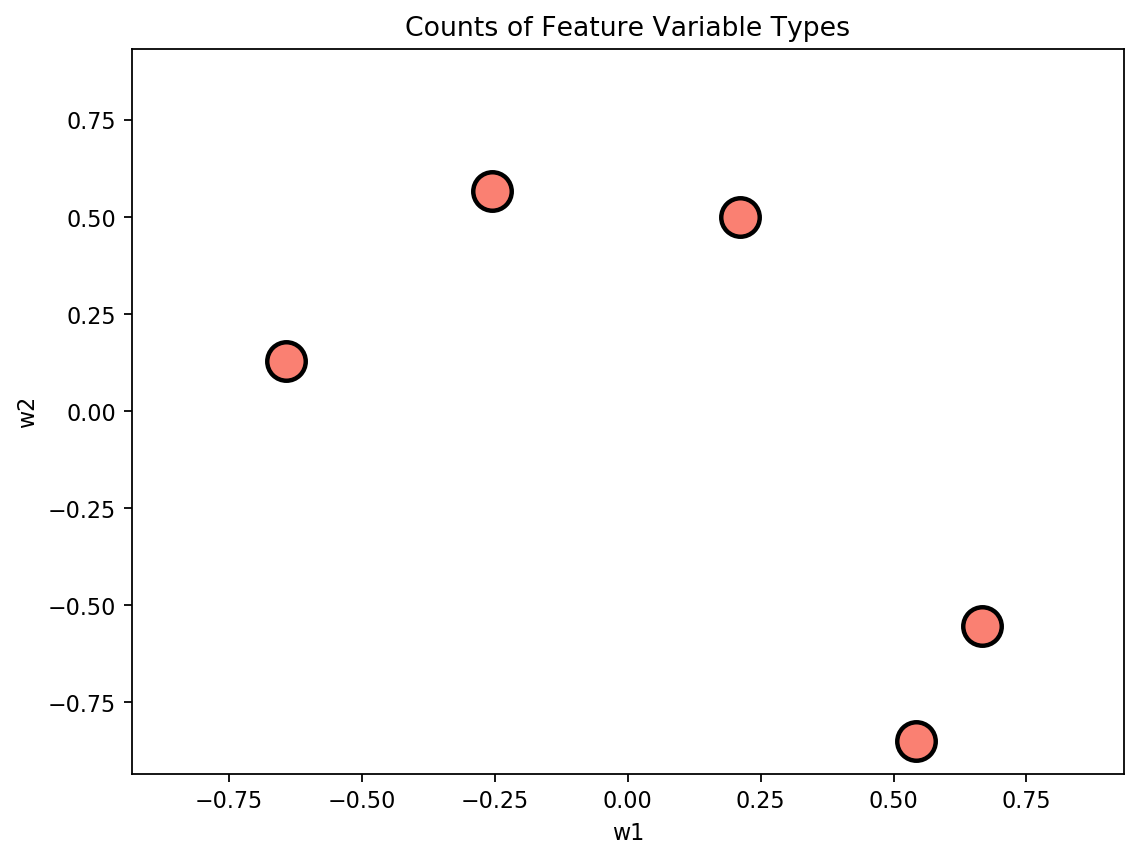

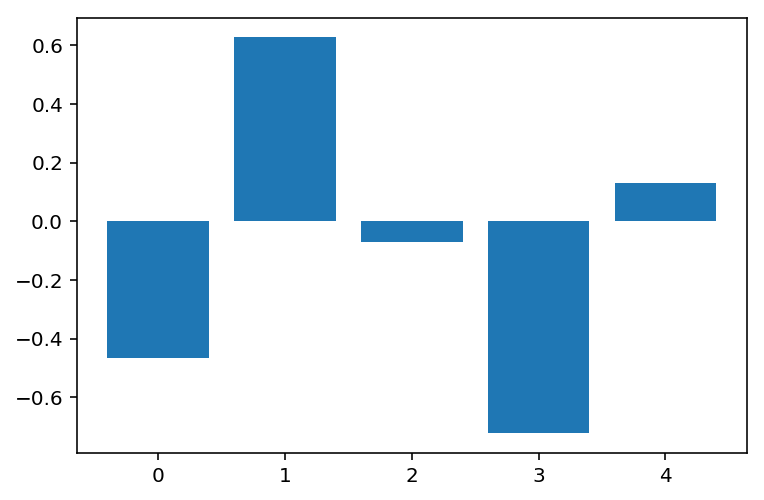

The loss is 0.4379982352256775
40000


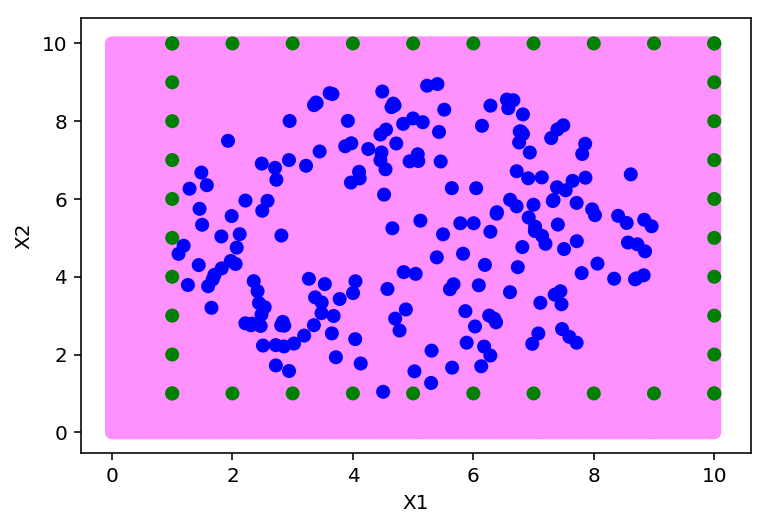

[[ 0.04772202  0.46324256]
 [ 0.63341916  0.08156249]
 [-0.71343106  0.36167634]
 [ 0.34965172 -0.25878543]
 [ 0.05836722  0.38508323]]


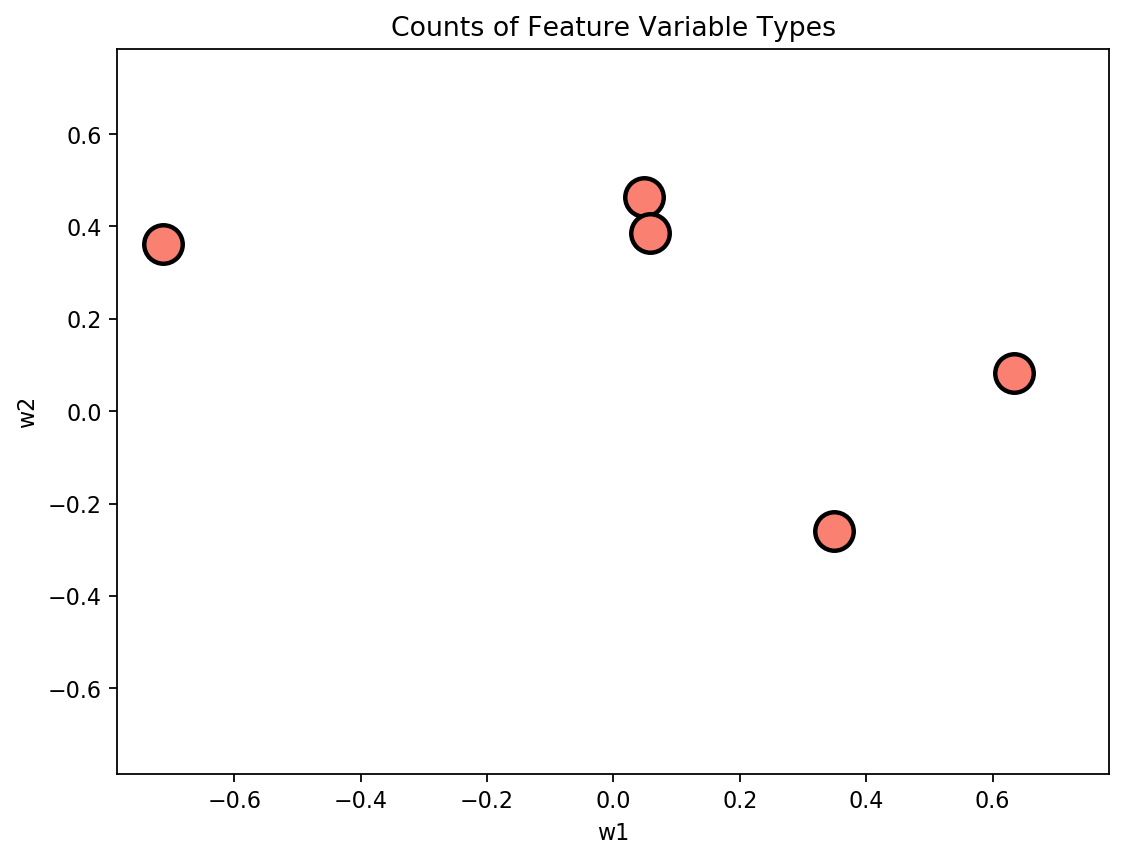

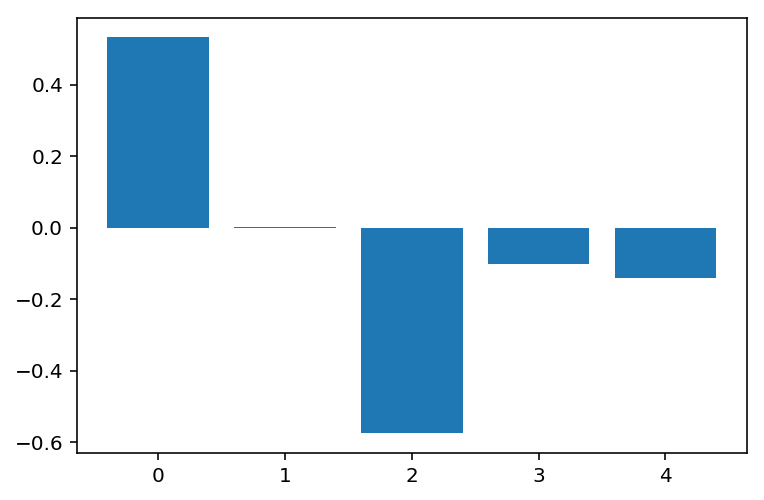

In [124]:
#get data for new model
x1 = []
for z in range(1,11):
    x1.append([z,1])
    x1.append((1,z))
    x1.append((10,z))
    x1.append((z,10))
y1 = [[0] for x in range(len(x1))]
x2 = []
y2 = []
for z in range(200):
    r = 4 * (random.random() ** 0.5)
    theta = random.random() * 2 * 3.14159
    x = 5 + r * cos(theta)
    y = 5 + r * sin(theta)
    x2.append([x,y])
    y2.append([1])

x = x1 + x2
y = y1 + y2





x = torch.FloatTensor(x)
y = torch.FloatTensor(y)
for ind in range(3):

    H = 5
    model = nn.Sequential(nn.Linear(d,H),
                         nn.ReLU(),
                         nn.Linear(H,1),
                          nn.Sigmoid())

    crit = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
    loss = train(x,y,model,crit)
    print("The loss is " + str(loss.tolist()))
    
             
    o = []

    def hook(module, input, output):
        o.append(output)
    
    model[1].register_forward_hook(hook)
    
    plot_regions(x,y,model)
    show_weights(model)
    a = np.array(o[0].tolist())
    t = np.sum(a, axis=0) / a.shape[0]
    
    

    plot_regions(x,y,model)
    show_weights(model)
    
    
    #plot_regions(x,y,model)
    #show_weights(model)
    show_layer(t)
    print('---------------------------------------------------------------')
    